In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### 시각화 할 때 한글 깨짐 방지 

In [ ]:
# 해당 셀 실행하고 런타임 다시시작 후 아래 셀 실행
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

## ◾Import 

In [ ]:
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from scipy import stats

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import  LabelEncoder
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

from tqdm import tqdm
import re
import glob
import zipfile
import os
import datetime

import warnings
warnings.filterwarnings('ignore')
# %matplotlib inline

## ◾데이터 불러오기 

In [ ]:
path = "/content/drive/MyDrive/01_Prediction/Dataset/"

In [ ]:
#--------------- train: 총 28개 상추 케이스 ---------------#

all_train_input_list = sorted(glob.glob(path + 'train_input/*.csv'))
all_train_target_list = sorted(glob.glob(path + 'train_target/*.csv'))

train_input_df = pd.DataFrame()
train_target_df = pd.DataFrame()

for input_path, target_path in tqdm(zip(all_train_input_list, all_train_target_list)):
  input_df = pd.read_csv(input_path)
  target_df = pd.read_csv(target_path)
  train_input_df = pd.concat([train_input_df, input_df], axis=0, ignore_index=True) # 행방향(위아래)으로 데이터프레임을 이어붙임 
  train_target_df = pd.concat([train_target_df, target_df], axis=0, ignore_index=True) # 행방향(위아래)으로 데이터프레임을 이어붙임

28it [00:00, 43.46it/s]


In [ ]:
#--------------- test: 총 5개 상추 케이스 ---------------#

all_test_input_list = sorted(glob.glob(path + 'test_input/*.csv'))
all_test_target_list = sorted(glob.glob(path + 'test_target/*.csv'))

test_input_df = pd.DataFrame()
test_target_df = pd.DataFrame()

for input_path, target_path in tqdm(zip(all_test_input_list, all_test_target_list)):
  input_df = pd.read_csv(input_path)
  target_df = pd.read_csv(target_path)
  test_input_df = pd.concat([test_input_df, input_df], axis=0, ignore_index=True) # 행방향(위아래)으로 데이터프레임을 이어붙임 
  test_target_df = pd.concat([test_target_df, target_df], axis=0, ignore_index=True) # 행방향(위아래)으로 데이터프레임을 이어붙임

5it [00:00, 60.99it/s]


In [ ]:
#--------------- submission: Test 상추 케이스 5개에 대한 일별 추론한 결과 ---------------#

zip_path = '/content/drive/MyDrive/01_Prediction/Dataset/sample_submission.zip'
extract_zip_folder_path = '/content/drive/MyDrive/01_Prediction/Submission'

with zipfile.ZipFile(zip_path, 'r') as zipObj:
    zipObj.extractall(extract_zip_folder_path)

submission_list = sorted(glob.glob(extract_zip_folder_path + '/*.csv'))

submission_df = pd.DataFrame()

for submission_path in tqdm(submission_list):
  df = pd.read_csv(submission_path)
  submission_df = pd.concat([submission_df, df], axis=0, ignore_index=True) # 행방향(위아래)으로 데이터프레임을 이어붙임 

100%|██████████| 5/5 [00:00<00:00, 154.35it/s]


## ◾EDA 

##### [ 데이터 둘러보기 ]

In [ ]:
#--------------- train: 총 28개 상추 케이스 ---------------#

print(train_input_df.shape, train_target_df.shape)

# train_input_df # 18816 rows(28*672) × 16 columns
# train_target_df # 784 rows(28*28) x 2 columns

(18816, 16) (784, 2)


In [ ]:
#--------------- test: 총 5개 상추 케이스 ---------------#

print(test_input_df.shape, test_target_df.shape)

# test_input_df # 3360 rows(5*672) × 16 columns
# test_target_df # 140 rows(5*28) x 2 columns

(3360, 16) (140, 2)


In [ ]:
#--------------- submission: Test 상추 케이스 5개에 대한 일별 추론한 결과 ---------------#

print(submission_df.shape)

# submission_df # 140 rows(5*28) × 2 columns

(140, 2)


In [ ]:
train_input_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18816 entries, 0 to 18815
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DAT       18816 non-null  int64  
 1   obs_time  18816 non-null  object 
 2   내부온도관측치   18816 non-null  float64
 3   내부습도관측치   18816 non-null  float64
 4   co2관측치    18816 non-null  float64
 5   ec관측치     18816 non-null  float64
 6   시간당분무량    18816 non-null  float64
 7   일간누적분무량   18816 non-null  float64
 8   시간당백색광량   18816 non-null  float64
 9   일간누적백색광량  18816 non-null  float64
 10  시간당적색광량   18816 non-null  float64
 11  일간누적적색광량  18816 non-null  float64
 12  시간당청색광량   18816 non-null  float64
 13  일간누적청색광량  18816 non-null  float64
 14  시간당총광량    18816 non-null  float64
 15  일간누적총광량   18816 non-null  float64
dtypes: float64(14), int64(1), object(1)
memory usage: 2.3+ MB


In [ ]:
train_target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DAT                 784 non-null    int64  
 1   predicted_weight_g  784 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 12.4 KB


In [ ]:
test_input_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DAT       3360 non-null   int64  
 1   obs_time  3360 non-null   object 
 2   내부온도관측치   3360 non-null   float64
 3   내부습도관측치   3360 non-null   float64
 4   co2관측치    3360 non-null   float64
 5   ec관측치     3360 non-null   float64
 6   시간당분무량    3360 non-null   float64
 7   일간누적분무량   3360 non-null   float64
 8   시간당백색광량   3360 non-null   float64
 9   일간누적백색광량  3360 non-null   float64
 10  시간당적색광량   3360 non-null   float64
 11  일간누적적색광량  3360 non-null   float64
 12  시간당청색광량   3360 non-null   float64
 13  일간누적청색광량  3360 non-null   float64
 14  시간당총광량    3360 non-null   float64
 15  일간누적총광량   3360 non-null   float64
dtypes: float64(14), int64(1), object(1)
memory usage: 420.1+ KB


In [ ]:
test_target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   DAT                 140 non-null    int64
 1   predicted_weight_g  140 non-null    int64
dtypes: int64(2)
memory usage: 2.3 KB


In [ ]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   DAT                 140 non-null    int64
 1   predicted_weight_g  140 non-null    int64
dtypes: int64(2)
memory usage: 2.3 KB


##### [ 피처 요약표 ]  
결과  
=> 음수값이 존재함. 데이터 전처리 단계에서 음수값 처리할 것.

In [ ]:
def resumetable(df):
    print(f'train dataset 피처 요약표: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': '피처'})
    summary['결측값 개수'] = df.isnull().sum().values
    summary['고윳값 개수'] = df.nunique().values
    summary['첫 번째 값'] = df.loc[0].values
    summary['두 번째 값'] = df.loc[1].values
    summary['최소값'] = df.min().values
    summary['최대값'] = df.max().values
    
    return summary

In [ ]:
resumetable(train_input_df)

train dataset 피처 요약표: (18816, 16)


,피처,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값,최소값,최대값
0,DAT,int64,0,28,0,0,0,27
1,obs_time,object,0,70,00:00,01:00,00:00,23:00:00.
2,내부온도관측치,float64,0,17416,25.3,25.680357,0.0,42.643334
3,내부습도관측치,float64,0,17964,81.835,81.264286,0.0,93.350002
4,co2관측치,float64,0,14246,536.016667,528.696429,60.4,1714.85
5,ec관측치,float64,0,16306,1.407439,1.409003,0.0,5.462324
6,시간당분무량,float64,0,1886,0.0,126.0,-653.26,3144.13
7,일간누적분무량,float64,0,6013,0.0,126.0,0.0,42855.23
8,시간당백색광량,float64,0,1146,0.0,0.0,-138371.2461,18564.6
9,일간누적백색광량,float64,0,4021,0.0,0.0,0.0,292014.9698


## ◾ Feature Engineering🔹

##### [ 피처명 한글화 ]

In [ ]:
train_input_df = train_input_df.rename(columns={'DAT': '생육일', 'obs_time': '측정시간'})
test_input_df = test_input_df.rename(columns={'DAT': '생육일', 'obs_time': '측정시간'})
train_target_df = train_target_df.rename(columns={'DAT': '생육일', 'predicted_weight_g': '생육일별_잎_중량'})
test_target_df = test_target_df.rename(columns={'DAT': '생육일', 'predicted_weight_g': '생육일별_잎_중량'})

##### [ 측정시간 수정 ]  
'14:59:59' -> '15:00:00'으로 바꾼 후 진행해야 함
(초단위가 59면 1초씩 더함)

In [ ]:
train_input_df.loc[train_input_df['측정시간'].astype(str).str.len()!=5].index   

Int64Index([  672,   673,   674,   675,   676,   677,   678,   679,   680,
              681,
            ...
            17462, 17463, 17464, 17465, 17466, 17467, 17468, 17469, 17470,
            17471],
           dtype='int64', length=4704)

In [ ]:
#--------------- train 총 28개 상추 케이스 ---------------#

train_input_df['측정시간'] = train_input_df['측정시간'].str.replace(".", "") #"00:00:00." -> "00:00:00"
plus_one_second = datetime.timedelta(seconds=1)

for i in tqdm(range(len(train_input_df['측정시간']))):
  if len(train_input_df['측정시간'][i]) < 6: #"00:00" 형식
    train_input_df['측정시간'][i] = train_input_df['측정시간'][i] + ":00"
  train_input_df['측정시간'][i] = pd.to_datetime(train_input_df['측정시간'][i], format='%H:%M:%S')
  # 초단위가 59면 1초씩 더함 
  str_time = str(train_input_df['측정시간'][i])
  if str_time[-2:] == '59':
    train_input_df['측정시간'][i] = train_input_df['측정시간'][i] + plus_one_second

train_input_df['측정시간'] = pd.to_datetime(train_input_df['측정시간'])
# train_input_df['측정시간'] = train_input_df['측정시간'].dt.hour #시

train_input_df = train_input_df.reset_index() 
train_input_df = train_input_df.drop(['index'], axis=1) 

train_input_df.head(5) # 18816 rows × 16 columns

100%|██████████| 18816/18816 [00:38<00:00, 488.79it/s]


,생육일,측정시간,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,0,1900-01-01 00:00:00,25.300000,81.835000,536.016667,1.407439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1900-01-01 01:00:00,25.680357,81.264286,528.696429,1.409003,126.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1900-01-01 02:00:00,25.273333,81.471666,532.833333,1.406913,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1900-01-01 03:00:00,25.355000,81.398334,545.566667,1.406689,126.0,252.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1900-01-01 04:00:00,25.391667,81.483333,558.583333,1.411070,0.0,252.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#--------------- test 총 5개 상추 케이스 ---------------#

test_input_df['측정시간'] = test_input_df['측정시간'].str.replace(".", "") #"00:00:00." -> "00:00:00"
plus_one_second = datetime.timedelta(seconds=1)

for i in tqdm(range(len(test_input_df['측정시간']))):
  if len(test_input_df['측정시간'][i]) < 6: #"00:00" 형식
    test_input_df['측정시간'][i] = test_input_df['측정시간'][i] + ":00"
  test_input_df['측정시간'][i] = pd.to_datetime(test_input_df['측정시간'][i], format='%H:%M:%S')
  # 초단위가 59면 1초씩 더함 
  str_time = str(test_input_df['측정시간'][i])
  if str_time[-2:] == '59':
    test_input_df['측정시간'][i] = test_input_df['측정시간'][i] + plus_one_second

test_input_df['측정시간'] = pd.to_datetime(test_input_df['측정시간'])
# test_input_df['측정시간'] = test_input_df['측정시간'].dt.hour #시

test_input_df = test_input_df.reset_index() 
test_input_df = test_input_df.drop(['index'], axis=1) 

test_input_df.head(5) # 3360 rows × 16 columns

100%|██████████| 3360/3360 [00:02<00:00, 1132.81it/s]


,생육일,측정시간,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,0,1900-01-01 00:00:00,26.260000,60.103333,471.883333,1.028971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1900-01-01 01:00:00,26.511864,59.930509,472.500000,1.030566,769.0,769.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1900-01-01 02:00:00,25.890000,59.745000,472.850000,1.034274,0.0,769.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1900-01-01 03:00:00,25.871666,60.023334,476.666667,1.034595,769.0,1538.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1900-01-01 04:00:00,26.356667,60.150000,468.833333,1.035417,0.0,1538.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## ◾ Feature Engineering - 피처 추가🔹

##### [ '상추' 피처 추가 ]  
상추 case별로 시각화하기 위함.

In [ ]:
#--------------- train 총 28개 상추 케이스 ---------------#

train_input_df['상추'] = "NaN"
train_input_df = train_input_df[['상추', '생육일', '측정시간','내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량',
                                '일간누적분무량', '시간당백색광량', '일간누적백색광량', '시간당적색광량', '일간누적적색광량', '시간당청색광량',
                                '일간누적청색광량', '시간당총광량', '일간누적총광량']]

for idx in range(28):
  train_input_df['상추'][672*idx:672*(idx+1)] = 'case' + str(idx+1)

train_input_df # 18816 rows × 17 columns

,상추,생육일,측정시간,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,case1,0,1900-01-01 00:00:00,25.300000,81.835000,536.016667,1.407439,0.0,0.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
1,case1,0,1900-01-01 01:00:00,25.680357,81.264286,528.696429,1.409003,126.0,126.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
2,case1,0,1900-01-01 02:00:00,25.273333,81.471666,532.833333,1.406913,0.0,126.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
3,case1,0,1900-01-01 03:00:00,25.355000,81.398334,545.566667,1.406689,126.0,252.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
4,case1,0,1900-01-01 04:00:00,25.391667,81.483333,558.583333,1.411070,0.0,252.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18811,case28,27,1900-01-01 19:00:00,26.030000,58.736667,448.500000,1.195415,0.0,2543.12,12.3764,146722.222,0.0,22253.7504,0.0,10462.6535,12.3764,179438.6259
18812,case28,27,1900-01-01 20:00:00,27.341666,58.373334,449.183333,1.190780,126.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259
18813,case28,27,1900-01-01 21:00:00,27.785000,58.711667,441.933333,1.185593,0.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259
18814,case28,27,1900-01-01 22:00:00,28.480000,58.121667,437.600000,1.179664,0.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259


In [ ]:
#--------------- train_target 총 28개 상추 케이스 ---------------#

train_target_df['상추'] = "NaN"
train_target_df = train_target_df[['상추', '생육일', '생육일별_잎_중량']]

for idx in range(28):
  train_target_df['상추'][28*idx:28*(idx+1)] = 'case' + str(idx+1)

train_target_df # 784 rows × 3 columns

,상추,생육일,생육일별_잎_중량
0,case1,1,0.167719
1,case1,2,0.181787
2,case1,3,0.265921
3,case1,4,0.423650
4,case1,5,0.475272
...,...,...,...
779,case28,24,64.875499
780,case28,25,74.002614
781,case28,26,76.342275
782,case28,27,82.621245


In [ ]:
#--------------- test 총 5개 상추 케이스 ---------------#

test_input_df['상추'] = "NaN"
test_input_df = test_input_df[['상추', '생육일', '측정시간', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량',
                              '일간누적분무량', '시간당백색광량', '일간누적백색광량', '시간당적색광량', '일간누적적색광량', '시간당청색광량',
                              '일간누적청색광량', '시간당총광량', '일간누적총광량']]

for idx in range(28):
  test_input_df['상추'][672*idx:672*(idx+1)] = 'case' + str(idx+1+28) # test_input_df 뒤에 붙일거기 때문에 case28~case32 이어야 함. 

test_input_df # 3360 rows × 17 columns

,상추,생육일,측정시간,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,case29,0,1900-01-01 00:00:00,26.260000,60.103333,471.883333,1.028971,0.00,0.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
1,case29,0,1900-01-01 01:00:00,26.511864,59.930509,472.500000,1.030566,769.00,769.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
2,case29,0,1900-01-01 02:00:00,25.890000,59.745000,472.850000,1.034274,0.00,769.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
3,case29,0,1900-01-01 03:00:00,25.871666,60.023334,476.666667,1.034595,769.00,1538.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
4,case29,0,1900-01-01 04:00:00,26.356667,60.150000,468.833333,1.035417,0.00,1538.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3355,case33,27,1900-01-01 19:00:00,24.478333,59.196667,442.383333,0.916185,0.00,2594.56,6.1882,146712.9397,0.0,22242.1668,0.0,10457.954,6.1882,179413.0605
3356,case33,27,1900-01-01 20:00:00,24.636667,58.330000,439.733333,0.916925,80.99,2675.55,0.0000,146712.9397,0.0,22242.1668,0.0,10457.954,0.0000,179413.0605
3357,case33,27,1900-01-01 21:00:00,24.103333,57.768333,434.516667,0.916777,0.00,2675.55,0.0000,146712.9397,0.0,22242.1668,0.0,10457.954,0.0000,179413.0605
3358,case33,27,1900-01-01 22:00:00,23.888333,57.255000,427.633333,0.918006,126.00,2801.55,0.0000,146712.9397,0.0,22242.1668,0.0,10457.954,0.0000,179413.0605


In [ ]:
#--------------- test_target 총 5개 상추 케이스 ---------------#

test_target_df['상추'] = "NaN"
test_target_df = test_target_df[['상추', '생육일', '생육일별_잎_중량']]

for idx in range(28):
  test_target_df['상추'][28*idx:28*(idx+1)] = 'case' + str(idx+1+28)

test_target_df # 140 rows × 3 columns

,상추,생육일,생육일별_잎_중량
0,case29,1,0
1,case29,2,0
2,case29,3,0
3,case29,4,0
4,case29,5,0
...,...,...,...
135,case33,24,0
136,case33,25,0
137,case33,26,0
138,case33,27,0


## ◾ 시각화 

##### [ train_input_df 28개 상추 case에 대한 피처별 분포 ]

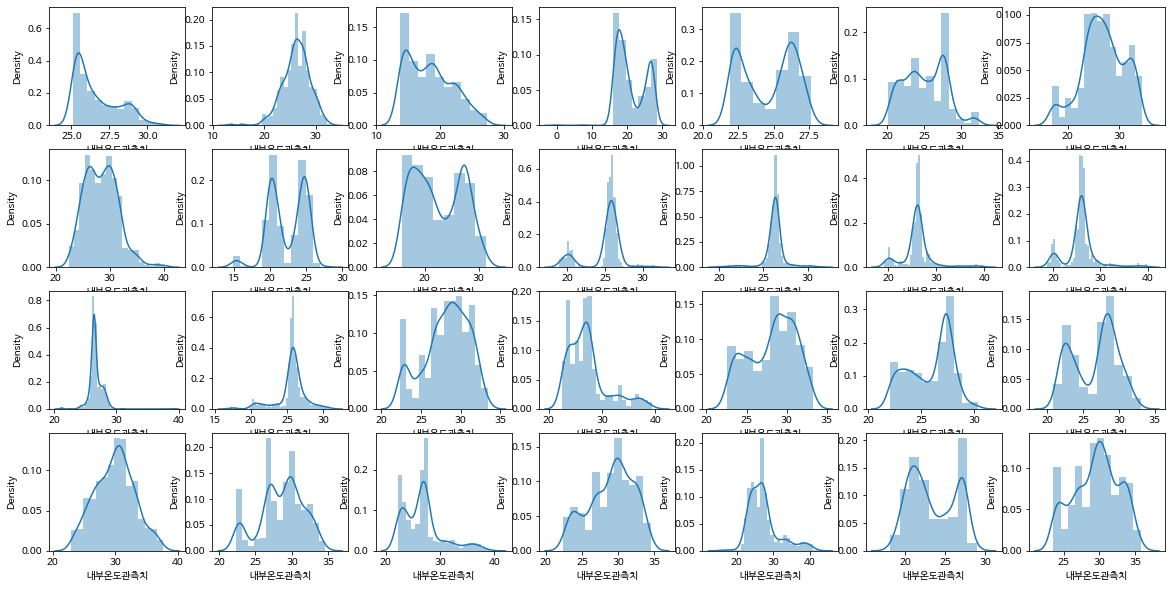

In [ ]:
# 내부온도관측치

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_input_df.loc[train_input_df['상추']=='case'+str(case_idx+1)]['내부온도관측치'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

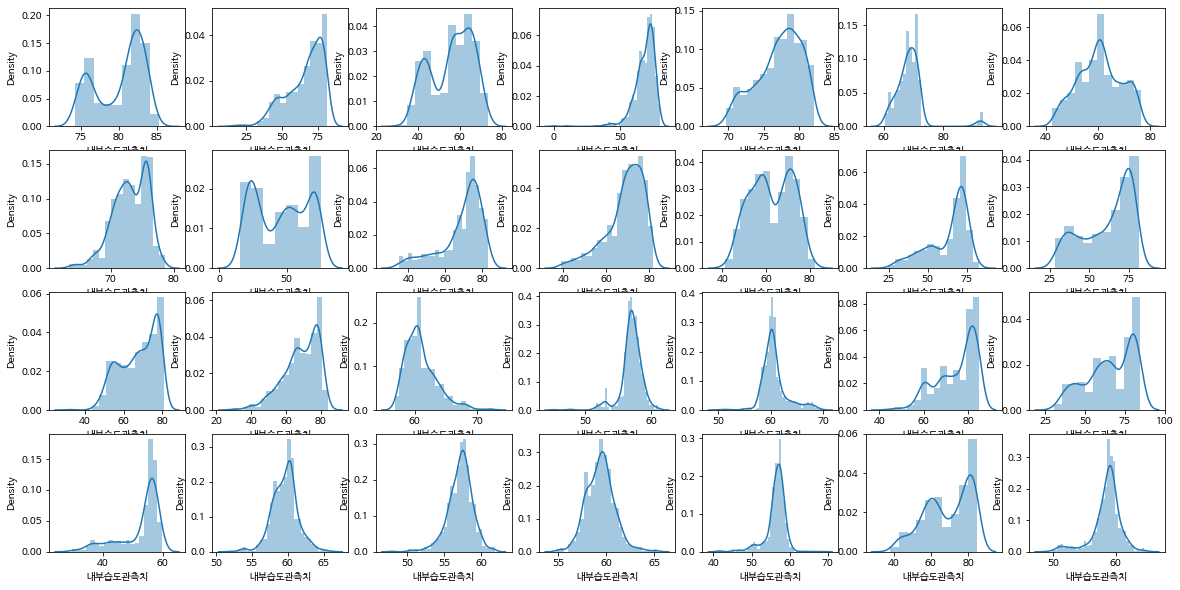

In [ ]:
# 내부습도관측치

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_input_df.loc[train_input_df['상추']=='case'+str(case_idx+1)]['내부습도관측치'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

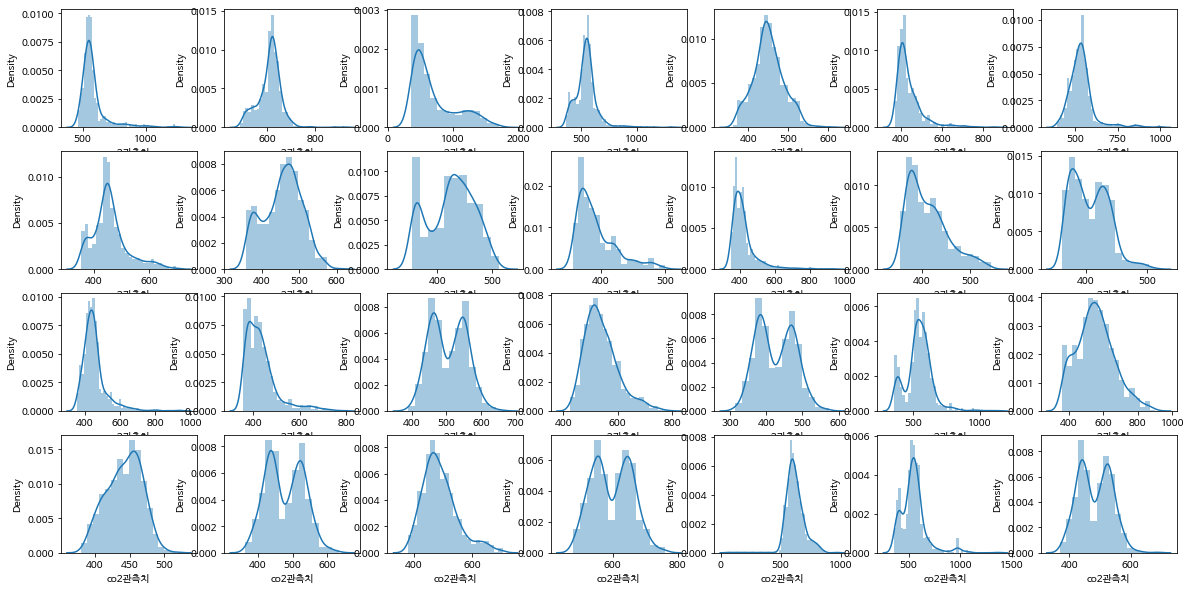

In [ ]:
# co2관측치

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_input_df.loc[train_input_df['상추']=='case'+str(case_idx+1)]['co2관측치'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

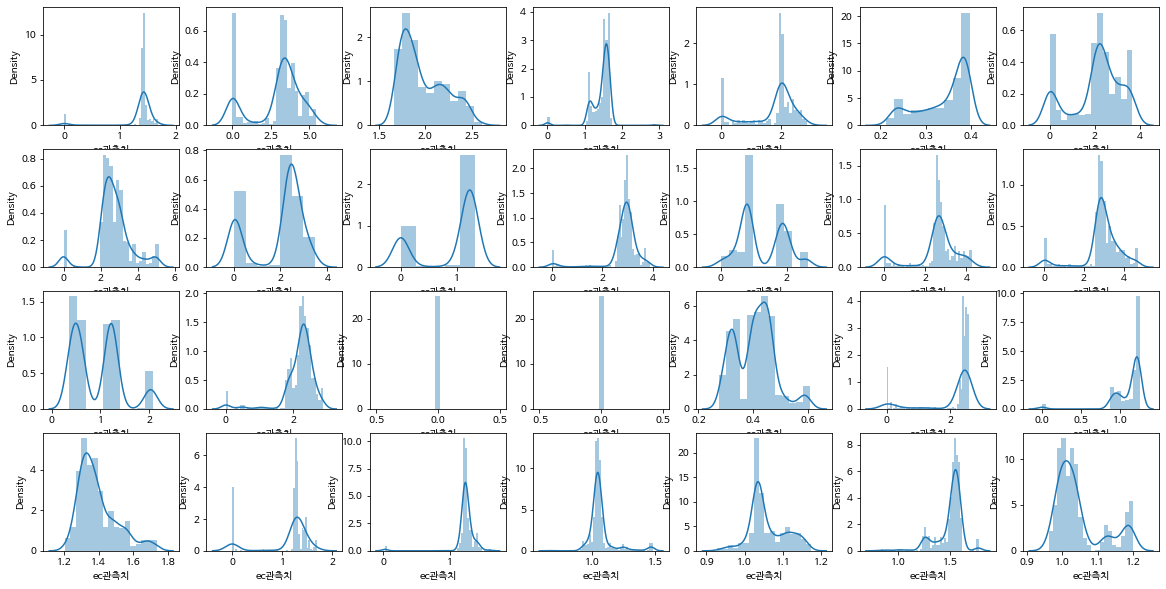

In [ ]:
# ec관측치

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_input_df.loc[train_input_df['상추']=='case'+str(case_idx+1)]['ec관측치'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

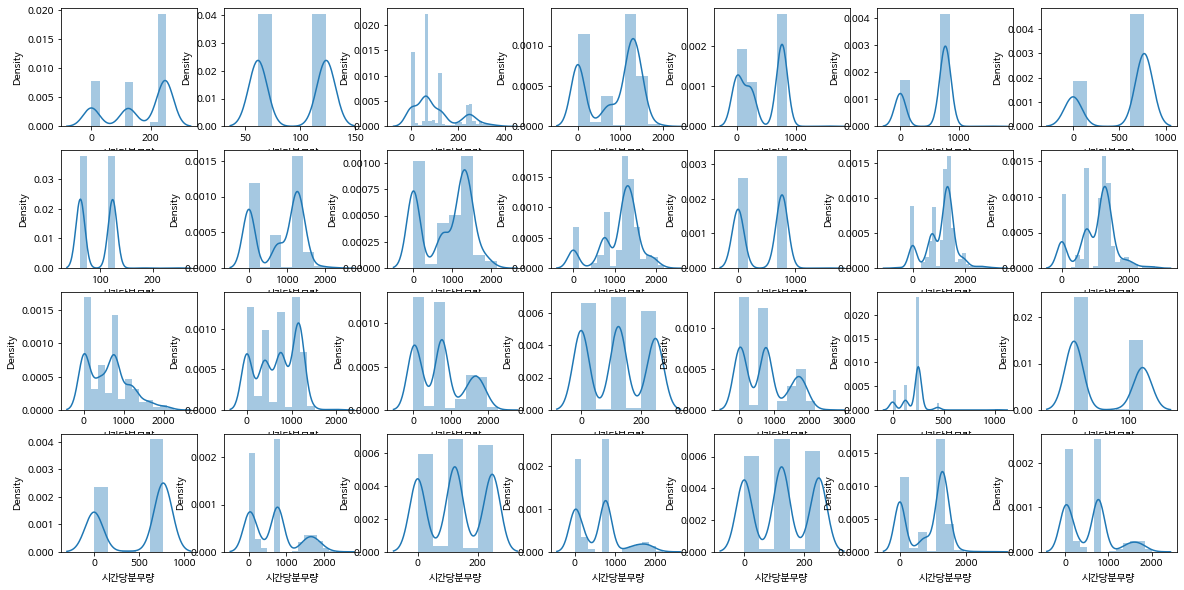

In [ ]:
# 시간당분무량

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_input_df.loc[train_input_df['상추']=='case'+str(case_idx+1)]['시간당분무량'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

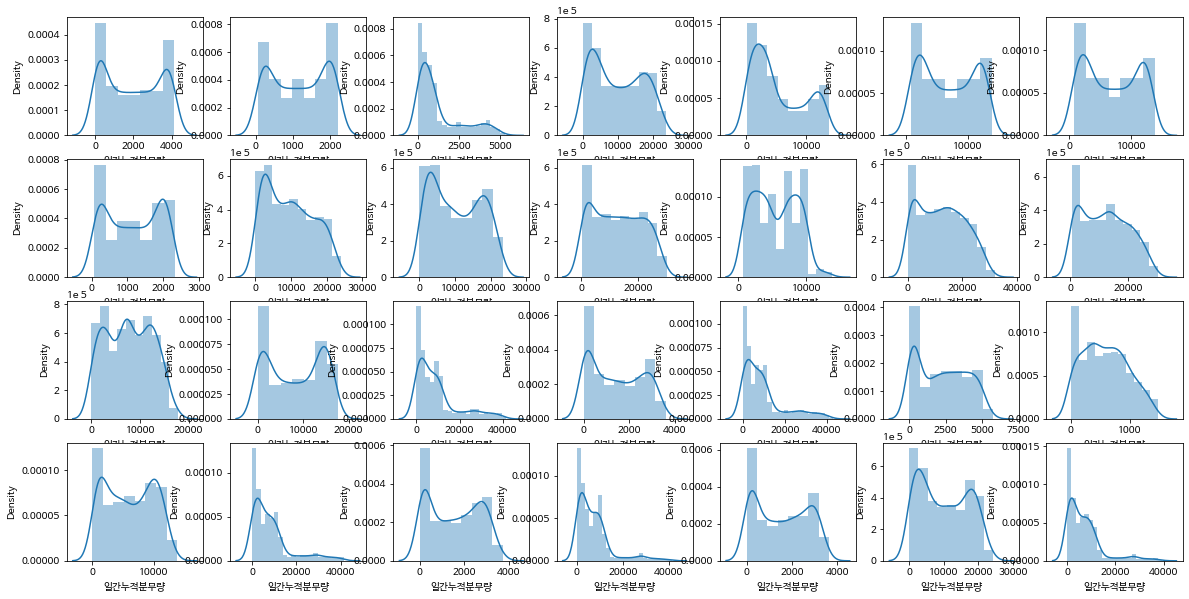

In [ ]:
# 일간누적분무량

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_input_df.loc[train_input_df['상추']=='case'+str(case_idx+1)]['일간누적분무량'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

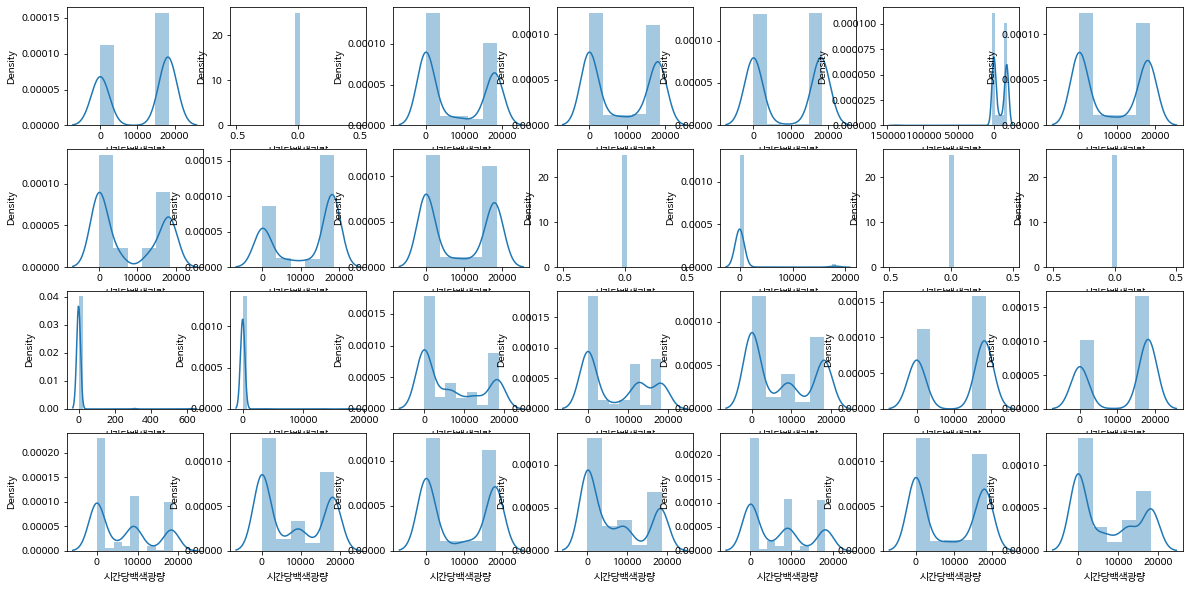

In [ ]:
# 시간당백색광량

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_input_df.loc[train_input_df['상추']=='case'+str(case_idx+1)]['시간당백색광량'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

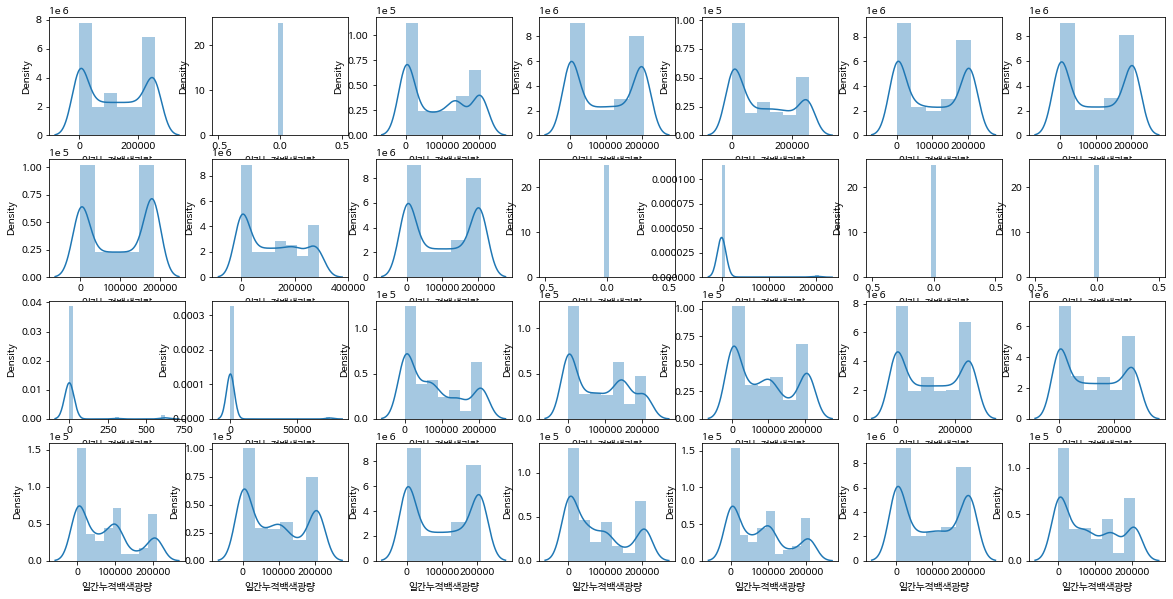

In [ ]:
# 일간누적백색광량

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_input_df.loc[train_input_df['상추']=='case'+str(case_idx+1)]['일간누적백색광량'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

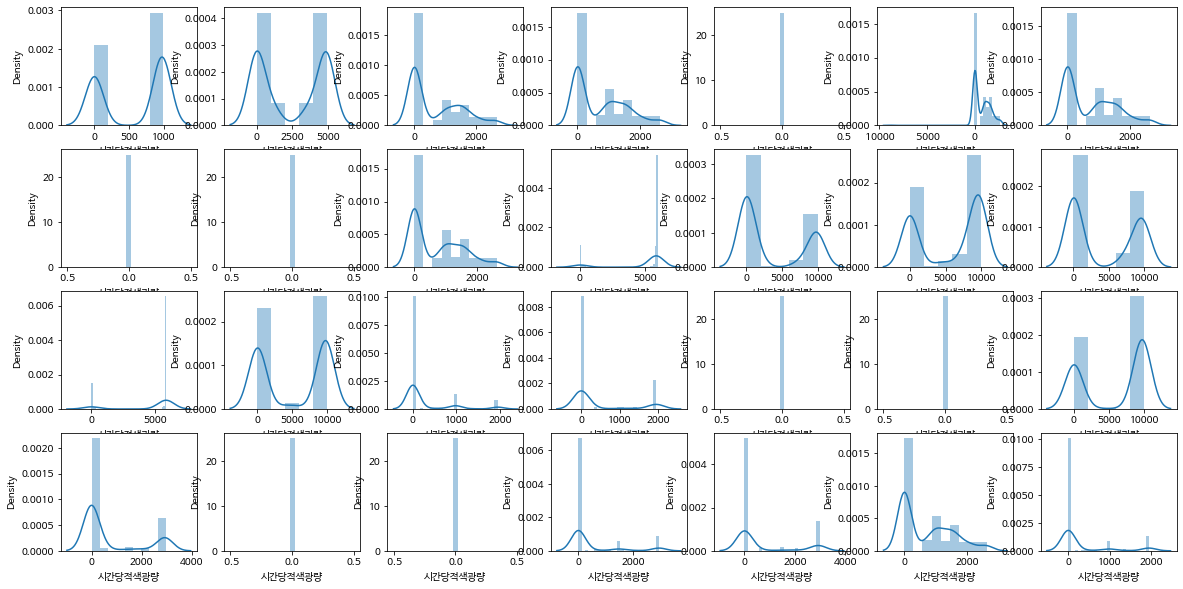

In [ ]:
# 시간당적색광량

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_input_df.loc[train_input_df['상추']=='case'+str(case_idx+1)]['시간당적색광량'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

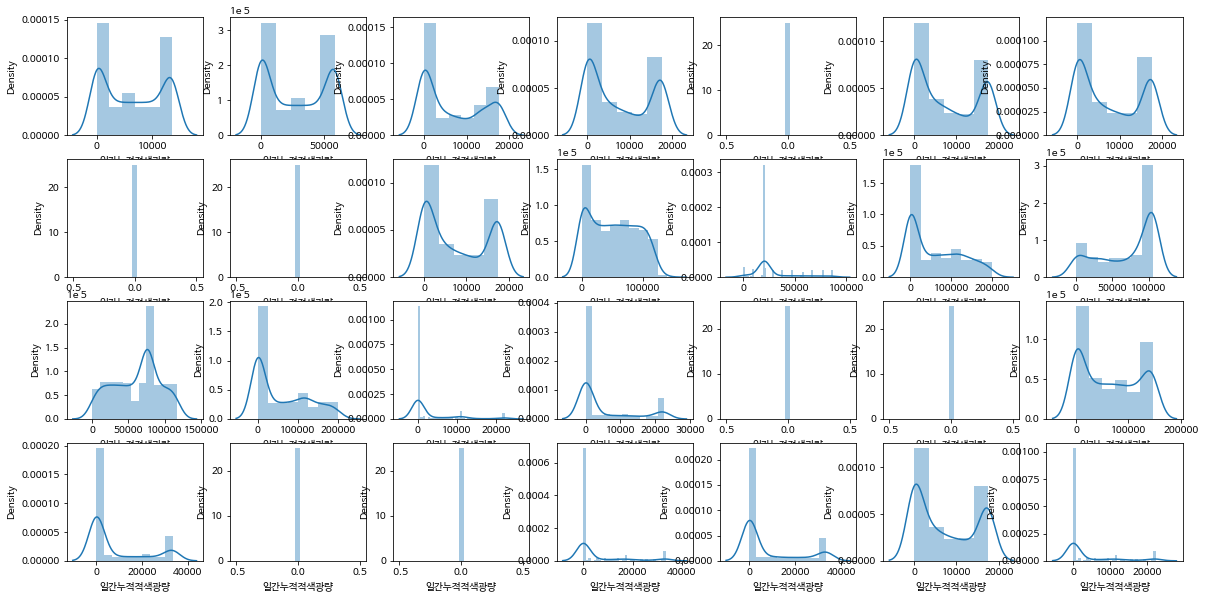

In [ ]:
# 일간누적적색광량

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_input_df.loc[train_input_df['상추']=='case'+str(case_idx+1)]['일간누적적색광량'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

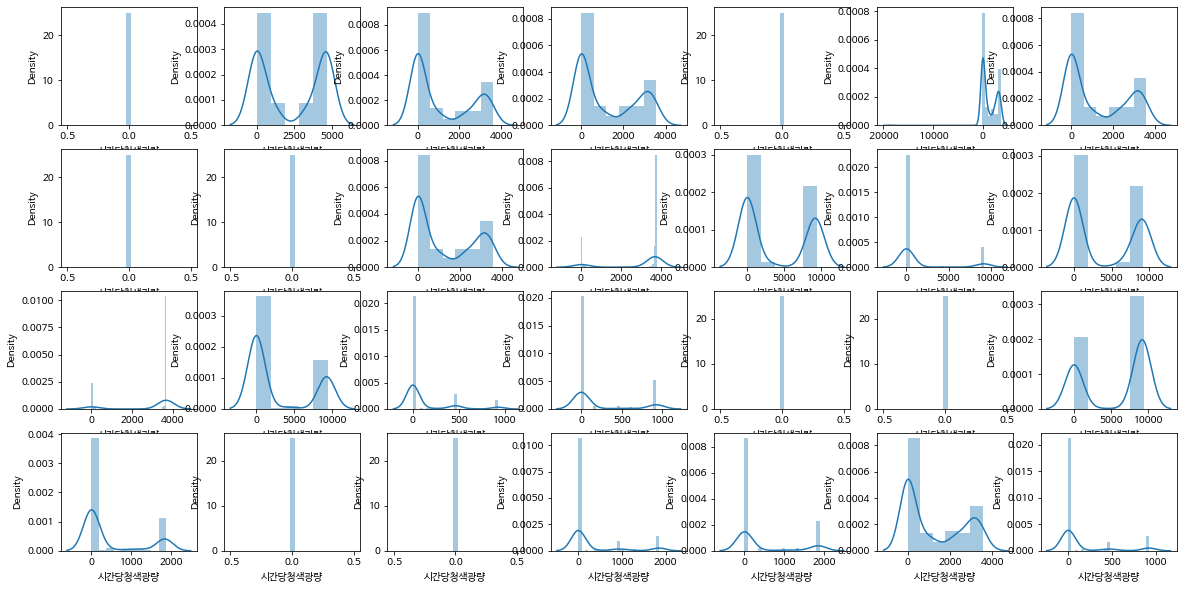

In [ ]:
# 시간당청색광량

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_input_df.loc[train_input_df['상추']=='case'+str(case_idx+1)]['시간당청색광량'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

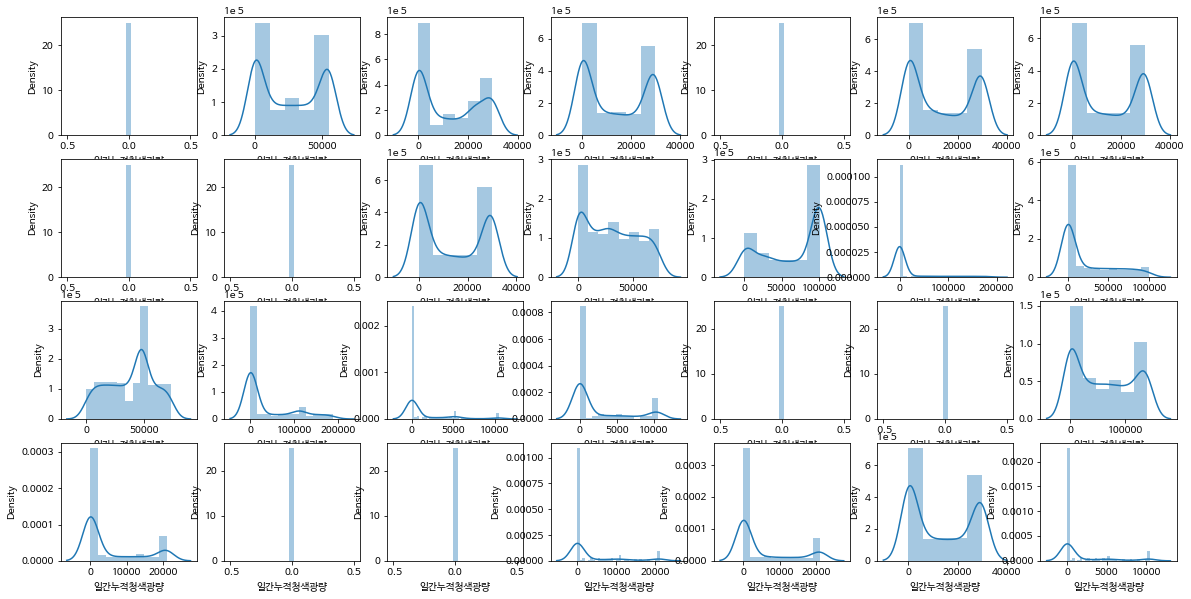

In [ ]:
# 일간누적청색광량

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_input_df.loc[train_input_df['상추']=='case'+str(case_idx+1)]['일간누적청색광량'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

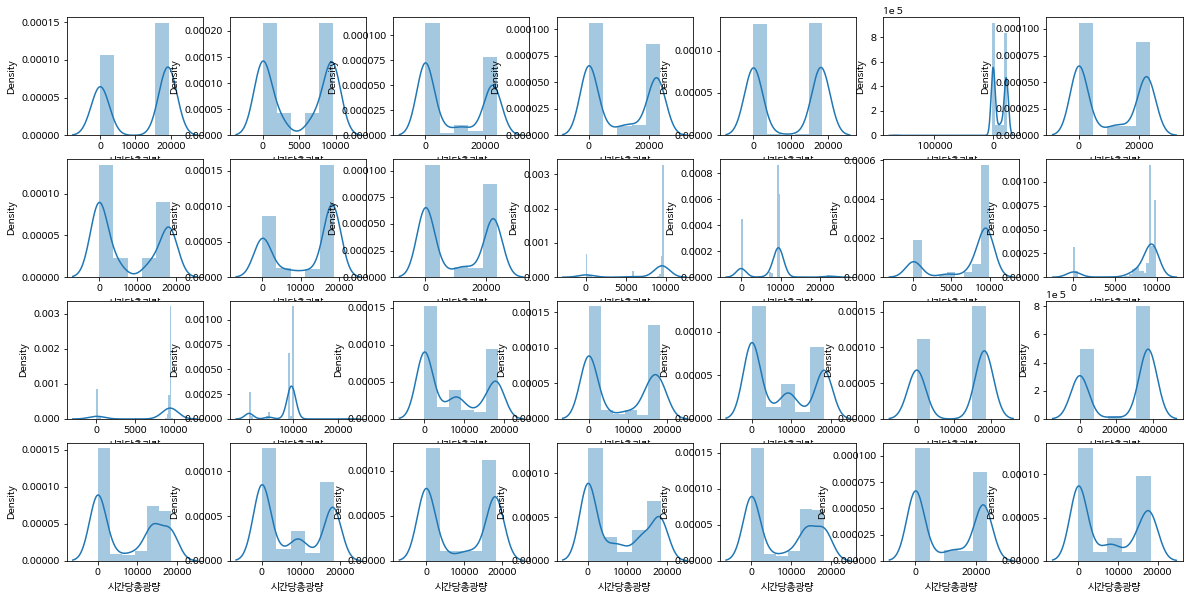

In [ ]:
# 시간당총광량

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_input_df.loc[train_input_df['상추']=='case'+str(case_idx+1)]['시간당총광량'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

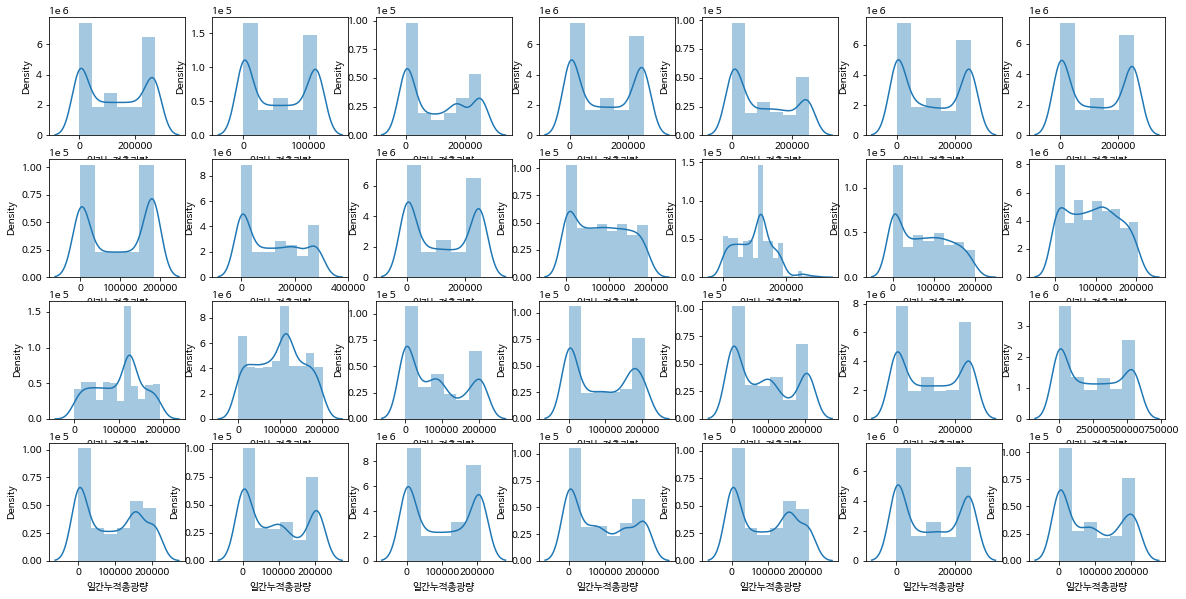

In [ ]:
# 일간누적총광량

fig, ax = plt.subplots(ncols=7, nrows=4, figsize=(20,10))

case_idx = 0
for row_idx in range(4):
  for col_idx in range(0, 7):
    sns.distplot(train_input_df.loc[train_input_df['상추']=='case'+str(case_idx+1)]['일간누적총광량'], ax=ax[row_idx, col_idx])
    case_idx = case_idx + 1

##### [ train_input_df 피처들을 수치 갯수, 데이터 갯수 순으로 정렬하여 막대그래프 그리기 ]

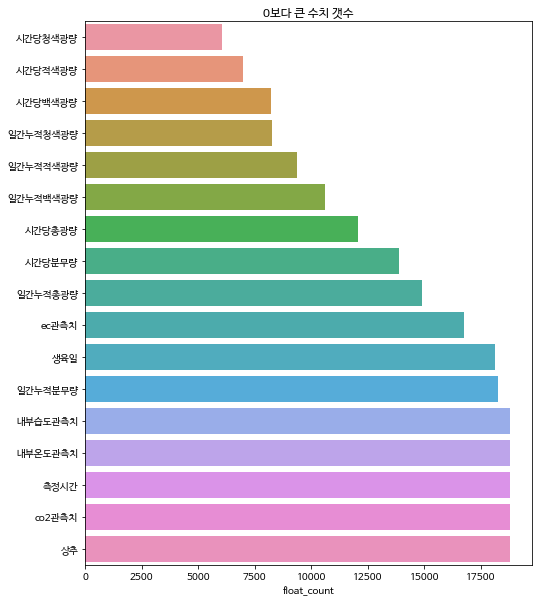

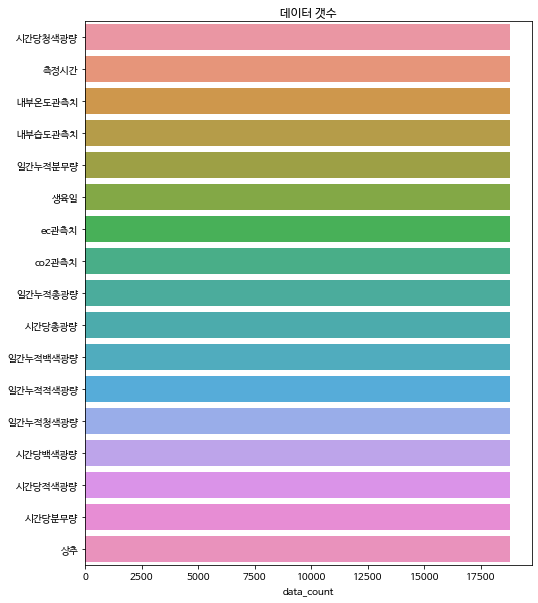

In [ ]:
# train_x, train_y = LoadData('train').read_train_raw()                           # train데이터를 전처리 없이 읽어온다.

data_count = (train_input_df.isnull()==False).sum()
null_count = (train_input_df.isnull()==True).sum()
float_count = (train_input_df.fillna(0).astype(bool)).sum()
data = [null_count, float_count, data_count]
index = ['null_count','float_count','data_count']
df = pd.DataFrame(data=data, index=index).T

df = df.sort_values('float_count')                                              # 수치 갯수 순으로 정렬하여
plt.figure(figsize=(8,10))
plt.title('0보다 큰 수치 갯수')
sns.barplot(y=df.index, x=df['float_count'])                                    # 막대그래프를 그린다.
plt.show()

df = df.sort_values('data_count')                                               # 데이터 갯수 기준으로 정렬하여
plt.figure(figsize=(8,10))
plt.title('데이터 갯수')
sns.barplot(y=df.index, x=df['data_count'])                                     # 막대그래프를 그린다.
plt.show()

##### [ train_input_df의 case별 피처들의 하루 24시간 변화량 살펴보기 ]

In [ ]:
FEATURES = train_input_df.columns

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go

for i in range(1, 29):
  train_case = train_input_df.loc[train_input_df['상추']=='case'+str(i)]

  SAMPLE_NUM = 24
  COLS = FEATURES[3:]
  fig = make_subplots(rows=len(COLS), cols=1, subplot_titles=COLS)
  for row, col in enumerate(COLS, 1):
      fig.add_trace(go.Scatter(x=np.arange(SAMPLE_NUM), y=train_case[col].iloc[:SAMPLE_NUM], showlegend=False,
                          mode='lines+markers', name=col, marker=dict(color="orange")), row=row, col=1)

  fig.update_layout(height=5000, width=1000, title_text='case'+str(i))
  fig.show()

## ◾ Data Pre-processing

##### [ train_input_df 잘못된 값 변경(음수 -> 다른 값으로 변경) ]  


In [ ]:
resumetable(train_input_df)

train dataset 피처 요약표: (18816, 17)


,피처,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값,최소값,최대값
0,상추,object,0,28,case1,case1,case1,case9
1,생육일,int64,0,28,0,0,0,27
2,측정시간,datetime64[ns],0,24,1900-01-01 00:00:00,1900-01-01 01:00:00,1900-01-01 00:00:00,1900-01-01 23:00:00
3,내부온도관측치,float64,0,17416,25.3,25.680357,0.0,42.643334
4,내부습도관측치,float64,0,17964,81.835,81.264286,0.0,93.350002
5,co2관측치,float64,0,14246,536.016667,528.696429,60.4,1714.85
6,ec관측치,float64,0,16306,1.407439,1.409003,0.0,5.462324
7,시간당분무량,float64,0,1886,0.0,126.0,-653.26,3144.13
8,일간누적분무량,float64,0,6013,0.0,126.0,0.0,42855.23
9,시간당백색광량,float64,0,1146,0.0,0.0,-138371.2461,18564.6


In [ ]:
# 시간당분무량 음수 -> 0
# 23.7950618671로 올라감 

# train_input_df[train_input_df['시간당분무량']<0].index  # [8665, 8713]
train_input_df['시간당분무량'].loc[[8665, 8713]] = 0
train_input_df.loc[[8665, 8713]]

# 일간누적분무량 다시 구하기 
for idx in tqdm(range(644)): # 644
    time_series = train_input_df[24*idx:24*(idx+1)]['시간당분무량']
    train_input_df[24*idx:24*(idx+1)]['일간누적분무량'] = time_series.cumsum()

100%|██████████| 644/644 [00:00<00:00, 2203.80it/s]


In [ ]:
# 시간당백색광량
# 다른 case 살펴보고 그 시간대에 늘어난 양만큼 비슷하게 숫자 정함

# train_input_df[train_input_df['시간당백색광량']<0] # 3375
train_input_df['시간당백색광량'].loc[[3375]] = 17744.6635 # 혹은 18255.1900	
train_input_df.loc[[3375]]

# 일간누적백색광량 다시 구하기 
for idx in tqdm(range(644)): # 644
    time_series = train_input_df[24*idx:24*(idx+1)]['시간당백색광량']
    train_input_df[24*idx:24*(idx+1)]['일간누적백색광량'] = time_series.cumsum()

100%|██████████| 644/644 [00:00<00:00, 2102.36it/s]


In [ ]:
# 시간당적색광량 
# 다른 case 살펴보고 그 시간대에 늘어난 양만큼 비슷하게 숫자 정함

# train_input_df[train_input_df['시간당적색광량']<0] # 3375
train_input_df['시간당적색광량'].loc[[3375]] = 1859.7644	 # 1659.7644에서 임의로 200 더함	(1659.7644는 3374행의 값 )
train_input_df.loc[[3375]]

# 일간누적적색광량 다시 구하기 
for idx in tqdm(range(644)): # 644
    time_series = train_input_df[24*idx:24*(idx+1)]['시간당적색광량']
    train_input_df[24*idx:24*(idx+1)]['일간누적적색광량'] = time_series.cumsum()

100%|██████████| 644/644 [00:00<00:00, 2092.86it/s]


In [ ]:
# 시간당청색광량 
# 다른 case 살펴보고 그 시간대에 늘어난 양만큼 비슷하게 숫자 정함

# train_input_df[train_input_df['시간당청색광량']<0] # 3375
train_input_df['시간당청색광량'].loc[[3375]] = 3519.6695	 # 3419.6695에서 임의로 100 더함	(3419.6695는 3374행의 값 )
train_input_df.loc[[3375]]

# 일간누적청색광량 다시 구하기 
for idx in tqdm(range(644)): # 644
    time_series = train_input_df[24*idx:24*(idx+1)]['시간당청색광량']
    train_input_df[24*idx:24*(idx+1)]['일간누적청색광량'] = time_series.cumsum()

100%|██████████| 644/644 [00:00<00:00, 1835.83it/s]


In [ ]:
# 시간당총광량 
# 다른 case 살펴보고 그 시간대에 늘어난 양만큼 비슷하게 숫자 정함

# train_input_df[train_input_df['시간당총광량']<0] # 3375
train_input_df['시간당총광량'].loc[[3375]] = 23634.6239	 # 23334.6239	에서 임의로 300 더함	(23334.6239	는 3374행의 값 )
train_input_df.loc[[3375]]

# 일간누적총광량 다시 구하기 
for idx in tqdm(range(644)): # 644
    time_series = train_input_df[24*idx:24*(idx+1)]['시간당총광량']
    train_input_df[24*idx:24*(idx+1)]['일간누적총광량'] = time_series.cumsum()

100%|██████████| 644/644 [00:00<00:00, 2131.85it/s]


In [ ]:
resumetable(train_input_df)

train dataset 피처 요약표: (18816, 17)


,피처,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값,최소값,최대값
0,상추,object,0,28,case1,case1,case1,case9
1,생육일,int64,0,28,0,0,0,27
2,측정시간,datetime64[ns],0,24,1900-01-01 00:00:00,1900-01-01 01:00:00,1900-01-01 00:00:00,1900-01-01 23:00:00
3,내부온도관측치,float64,0,17416,25.3,25.680357,0.0,42.643334
4,내부습도관측치,float64,0,17964,81.835,81.264286,0.0,93.350002
5,co2관측치,float64,0,14246,536.016667,528.696429,60.4,1714.85
6,ec관측치,float64,0,16306,1.407439,1.409003,0.0,5.462324
7,시간당분무량,float64,0,1884,0.0,126.0,0.0,3144.13
8,일간누적분무량,float64,0,6156,0.0,126.0,0.0,42855.23
9,시간당백색광량,float64,0,1145,0.0,0.0,0.0,18564.6


## ◾ Feature Engineering - 파생 피처 추가 (온도, 습도 관련)🔹

*   생육 적온: 15~20도 
*   최저한계온도: 8, 최고한계온도: 25  
*   10도 이하이거나 15도 이상에서는 잎의 분화가 거의 이루어지지 않거나 잎이 증가하지 않음  
*   30도 이상의 고온과 5도 이하의 저온에서는 발아가 거의 되지 않음  
*   우리나라는 여름에는 지나치게 고온으로 특히, 시설 내에서는 환기시설을 모두 개방하고도 실내온도가35~40oC 정도로 올라가는데, 이러한 상태에서는 많은 작물의 생육적온을 벗어난 온도로서 고온장해를 받는다.  
*   불쾌 지수 = 0.81 × 온도 + 0.01 × 습도 x (0.99 × 온도 -14.3) +46.3  
---
=> 총 3가지 파생 피처 생성   
   **'적정_내부온도관측_누적시간'**, **'부적정_내부온도관측_누적시간'**, **'불쾌지수'** 

##### [ '적정_내부온도관측_누적시간' ]

In [ ]:
def good_internal_temperature(df):
  df['적정_내부온도관측_누적시간'] = 0

  # 내부온도관측치 15-20℃
  index_적정_내부온도관측 = df.loc[(df['내부온도관측치']>=15) & (df['내부온도관측치']<=20)].index

  # case 별로 적정_내부온도관측_누적시간 구하기 
  df.loc[index_적정_내부온도관측, '적정_내부온도관측_누적시간'] = 1
  df['적정_내부온도관측_누적시간'] = df.groupby(['상추'])['적정_내부온도관측_누적시간'].apply(lambda x: x.cumsum())
  return df

train_input_df = good_internal_temperature(train_input_df)
test_input_df = good_internal_temperature(test_input_df)

##### [ '부적정_내부온도관측_누적시간' ]

In [ ]:
def bad_internal_temperature(df):
  df['부적정_내부온도관측_누적시간'] = 0

  # 내부온도관측치 30℃이상, 5℃이하
  index_부적정_내부온도관측 = df.loc[(df['내부온도관측치']>=30) | (df['내부온도관측치']<=5)].index

  # case 별로 부적정_내부온도관측_누적시간 구하기 
  df.loc[index_부적정_내부온도관측, '부적정_내부온도관측_누적시간'] = 1
  df['부적정_내부온도관측_누적시간'] = df.groupby(['상추'])['부적정_내부온도관측_누적시간'].apply(lambda x: x.cumsum())
  return df

train_input_df = bad_internal_temperature(train_input_df)
test_input_df = bad_internal_temperature(test_input_df)

##### [ '불쾌지수' ]


In [ ]:
#--------------- train 총 28개 상추 케이스 ---------------#

train_input_df['불쾌지수'] = (0.81*train_input_df['내부온도관측치']) + ((0.01*train_input_df['내부습도관측치'])*(0.99*train_input_df['내부온도관측치']-14.3)) + 46.3

In [ ]:
#--------------- test 총 5개 상추 케이스 ---------------#

test_input_df['불쾌지수'] = (0.81*test_input_df['내부온도관측치']) + ((0.01*test_input_df['내부습도관측치'])*(0.99*test_input_df['내부온도관측치']-14.3)) + 46.3

##### columns 순서 정리 

In [ ]:
train_input_df = train_input_df[['상추', '생육일', '측정시간', 
                                 '내부온도관측치', '적정_내부온도관측_누적시간', '부적정_내부온도관측_누적시간',
                                 '내부습도관측치', 
                                 '불쾌지수',
                                 'co2관측치', 'ec관측치', 
                                 '시간당분무량', '일간누적분무량', 
                                 '시간당백색광량', '일간누적백색광량', 
                                 '시간당적색광량', '일간누적적색광량', 
                                 '시간당청색광량', '일간누적청색광량', 
                                 '시간당총광량', '일간누적총광량']]

test_input_df = test_input_df[['상추', '생육일', '측정시간', 
                                 '내부온도관측치', '적정_내부온도관측_누적시간', '부적정_내부온도관측_누적시간',
                                 '내부습도관측치', 
                                 '불쾌지수',
                                 'co2관측치', 'ec관측치', 
                                 '시간당분무량', '일간누적분무량', 
                                 '시간당백색광량', '일간누적백색광량', 
                                 '시간당적색광량', '일간누적적색광량', 
                                 '시간당청색광량', '일간누적청색광량', 
                                 '시간당총광량', '일간누적총광량']]

## ◾ Feature Engineering - 파생 피처 추가 (co2 관련)🔹

*   온실 내의 CO2 농도를 1,000~1,500ppm 수준으로 공급하면 엽채류(상추, 시금치 등)와 과채류(고추, 토마토, 오이 등)의 수량이 각각 2.4배, 1.4배 향상되었다.
---
=> 총 2가지 파생 피처 생성  
**'적정_co2관측_누적시간'** , **'부적정_co2관측_누적시간'**

##### [ '적정_co2관측_누적시간' ]

In [ ]:
def good_co2_time(df):
  df['적정_co2관측_누적시간'] = 0

  # CO2 농도 1,000~1,500ppm (어차피 최대값 1,200)
  index_적정_co2관측_누적시간 = df.loc[(df['ec관측치']>=1000) & (df['ec관측치']<=1500)].index

  # case 별로 적정_co2관측_누적시간 구하기 
  df.loc[index_적정_co2관측_누적시간, '적정_co2관측_누적시간'] = 1
  df['적정_co2관측_누적시간'] = df.groupby(['상추'])['적정_co2관측_누적시간'].apply(lambda x: x.cumsum())
  return df

train_input_df = good_co2_time(train_input_df)
test_input_df = good_co2_time(test_input_df)

##### [ '부적정_co2관측_누적시간' ]

In [ ]:
def bad_co2_time(df):
  df['부적정_co2관측_누적시간'] = 0

  # CO2 농도 1,000ppm 미만 (어차피 최대값 1,200)
  index_부적정_co2관측_누적시간 = df.loc[(df['ec관측치']<1000)].index

  # case 별로 부적정_co2관측_누적시간 구하기 
  df.loc[index_부적정_co2관측_누적시간, '부적정_co2관측_누적시간'] = 1
  df['부적정_co2관측_누적시간'] = df.groupby(['상추'])['부적정_co2관측_누적시간'].apply(lambda x: x.cumsum())
  return df

train_input_df = bad_co2_time(train_input_df)
test_input_df = bad_co2_time(test_input_df)

##### columns 순서 정리 

In [ ]:
train_input_df = train_input_df[['상추', '생육일', '측정시간', 
                                 '내부온도관측치', '적정_내부온도관측_누적시간', '부적정_내부온도관측_누적시간',
                                 '내부습도관측치', 
                                 'co2관측치', '적정_co2관측_누적시간', '부적정_co2관측_누적시간', 
                                 'ec관측치',
                                 '시간당분무량', '일간누적분무량', 
                                 '시간당백색광량', '일간누적백색광량', 
                                 '시간당적색광량', '일간누적적색광량', 
                                 '시간당청색광량', '일간누적청색광량', 
                                 '시간당총광량', '일간누적총광량']]

test_input_df = test_input_df[['상추', '생육일', '측정시간', 
                                 '내부온도관측치', '적정_내부온도관측_누적시간', '부적정_내부온도관측_누적시간',
                                 '내부습도관측치', 
                                 'co2관측치', '적정_co2관측_누적시간', '부적정_co2관측_누적시간', 
                                 'ec관측치',
                                 '시간당분무량', '일간누적분무량', 
                                 '시간당백색광량', '일간누적백색광량', 
                                 '시간당적색광량', '일간누적적색광량', 
                                 '시간당청색광량', '일간누적청색광량', 
                                 '시간당총광량', '일간누적총광량']]

## ◾ Feature Engineering - 파생 피처 추가 (ec 관련)🔹

*  EC는 '전기전도도'라고 한다. 토양의 무기염류 및 NaCl 함유량을 알아볼 수 있다.   
비료를 투입해 양분이 많아지면 전기전도도 측정값은 커지게 되고, 식물에 의해 양분이 소비되고 나면 측정값은 작아지게 된다.  
EC가 너무 높으면 작물에 피해가 발생할 수 있다.  
*  보통 작물 재배에 적합한 토양의 적정EC는 2.0ds/m 이하이며, 이상에서는 작물의 생육이 저하되고 심할 경우 장해를 일으킨다.  
(Ex. 상추는 1.5 이하로 관리하는것이 바람직 하다.)  
*  상추 생육에 알맞은 전기전도도(EC)는 1.2~1.6 dS/m 인데 계절별로 여름철에는 1.2 dS/m 까지 낮춰주는 것이 좋고 겨울철에는 1.6 dS/m로 유지하는 것이 좋다.  
---
=> 총 4가지 파생 피처 생성 

*   ec관측치 1.2℃이상, 1.6℃이하 -> ***'적정 EC관측 누적시간'*** 피처
*   여름철(8월 기준. 온도 19.7-26.7℃, 습도 78-79%) & ec관측치 1.2이상~1.3미만  -> ***'여름철 적정 EC관측 누적시간'*** 피처   
*   겨울철(1월 기준. 온도 –6.9℃-3.6℃, 습도  61-63%) & ec관측치 1.6이상~1.7미만 -> ***'겨울철 적정 EC관측 누적시간'*** 피처   
*   ec관측치 1.2 미만, 1.6 초과 -> **'부적적 EC관측 누적시간'** 피처 



##### [ '적정_EC관측_누적시간' ]

In [ ]:
def good_ec_time(df):
  df['적정_EC관측_누적시간'] = 0

  # ec관측치 1.2℃이상, 1.6℃이하
  index_적정_EC관측_누적시간 = df.loc[(df['ec관측치']>=1.2) & (df['ec관측치']<=1.6)].index

  # case 별로 적정_EC관측_누적시간 구하기 
  df.loc[index_적정_EC관측_누적시간, '적정_EC관측_누적시간'] = 1
  df['적정_EC관측_누적시간'] = df.groupby(['상추'])['적정_EC관측_누적시간'].apply(lambda x: x.cumsum())
  return df

train_input_df = good_ec_time(train_input_df)
test_input_df = good_ec_time(test_input_df)

##### [ '여름철_적정_EC관측_누적시간']

In [ ]:
def summer_good_ec_time(df):
  df['여름철_적정_EC관측_누적시간'] = 0

  # 여름철(8월 기준. 온도 19.7-26.7℃, 습도 78-79%) & ec관측치 1.2이상~1.3미만
  index_여름철_적정_EC관측_누적시간 = df.loc[
        ((df['내부온도관측치']>=19.7) & (df['내부온도관측치']<=26.7)) 
      & ((df['내부습도관측치']>=78) & (df['내부습도관측치']<=79))
      & ((df['ec관측치']>=1.2) & (df['ec관측치']<=1.6))].index

  # case 별로 여름철_적정_EC관측_누적시간 구하기 
  df.loc[index_여름철_적정_EC관측_누적시간, '여름철_적정_EC관측_누적시간'] = 1
  df['여름철_적정_EC관측_누적시간'] = df.groupby(['상추'])['여름철_적정_EC관측_누적시간'].apply(lambda x: x.cumsum())
  return df

train_input_df = summer_good_ec_time(train_input_df)
test_input_df = summer_good_ec_time(test_input_df)

##### [ '겨울철_적정_EC관측_누적시간' ]

In [ ]:
def winter_good_ed_time(df):
  df['겨울철_적정_EC관측_누적시간'] = 0

  # 겨울철(1월 기준. 온도 –6.9℃-3.6℃, 습도 61-63%) & ec관측치 1.6이상~1.7미만
  index_겨울철_적정_EC관측_누적시간 = df.loc[
        ((df['내부온도관측치']>=-6.9) & (df['내부온도관측치']<=-3.6)) 
      & ((df['내부습도관측치']>=61) & (df['내부습도관측치']<=63))
      & ((df['ec관측치']>=1.6) & (df['ec관측치']<1.7))].index

  # case 별로 겨울철_적정_EC관측_누적시간 구하기 
  df.loc[index_겨울철_적정_EC관측_누적시간, '겨울철_적정_EC관측_누적시간'] = 1
  df['겨울철_적정_EC관측_누적시간'] = df.groupby(['상추'])['겨울철_적정_EC관측_누적시간'].apply(lambda x: x.cumsum())
  return df

train_input_df = winter_good_ed_time(train_input_df)
test_input_df = winter_good_ed_time(test_input_df)

##### [ '부적정_EC관측_누적시간' ]

In [ ]:
def bad_ec_time(df):
  df['부적정_EC관측_누적시간'] = 0

  # ec관측치 1.2℃미만, 1.6℃초과
  index_부적정_EC관측_누적시간 = df.loc[(df['ec관측치']>1.2) | (df['ec관측치']<1.6)].index

  # case 별로 부적정_EC관측_누적시간 구하기 
  df.loc[index_부적정_EC관측_누적시간, '부적정_EC관측_누적시간'] = 1
  df['부적정_EC관측_누적시간'] = df.groupby(['상추'])['부적정_EC관측_누적시간'].apply(lambda x: x.cumsum())
  return df

train_input_df = bad_ec_time(train_input_df)
test_input_df = bad_ec_time(test_input_df)

##### columns 순서 정리 

In [ ]:
train_input_df = train_input_df[['상추', '생육일', '측정시간', 
                                 '내부온도관측치', '적정_내부온도관측_누적시간', '부적정_내부온도관측_누적시간',
                                 '내부습도관측치', 
                                 'co2관측치', '적정_co2관측_누적시간', '부적정_co2관측_누적시간',
                                 'ec관측치', '적정_EC관측_누적시간', '부적정_EC관측_누적시간', '여름철_적정_EC관측_누적시간', '겨울철_적정_EC관측_누적시간',
                                 '시간당분무량', '일간누적분무량', 
                                 '시간당백색광량', '일간누적백색광량', 
                                 '시간당적색광량', '일간누적적색광량', 
                                 '시간당청색광량', '일간누적청색광량', 
                                 '시간당총광량', '일간누적총광량']]

test_input_df = test_input_df[['상추', '생육일', '측정시간', 
                                 '내부온도관측치', '적정_내부온도관측_누적시간', '부적정_내부온도관측_누적시간',
                                 '내부습도관측치', 
                                 'co2관측치', '적정_co2관측_누적시간', '부적정_co2관측_누적시간',
                                 'ec관측치', '적정_EC관측_누적시간', '부적정_EC관측_누적시간', '여름철_적정_EC관측_누적시간', '겨울철_적정_EC관측_누적시간',
                                 '시간당분무량', '일간누적분무량', 
                                 '시간당백색광량', '일간누적백색광량', 
                                 '시간당적색광량', '일간누적적색광량', 
                                 '시간당청색광량', '일간누적청색광량', 
                                 '시간당총광량', '일간누적총광량']]

##  ◾ Feature Engineering - 파생 피처 추가 (광 관련)🔹

*   발아 후 상추의 생육 과정에서 광보상점은 1,500Lux이고 광포화점은 2만5,000Lux이다.
*   일장은 하루 낮의 길이를 말하는데 자연일장은 지역과 계절에 따라 달라 적도지방에서는 연중 12시간이며 위도가 높아질수록 여름의 일장은 길어지고 겨울은 짧아지게 된다. 
*   식물의 생육은 일장에 따라 여러가지 반응을 보이는데 이를 일장효과라고 한다. 
---
=> 총 2가지 파생 피처 생성  
**'광주기_명기_누적시간'**, **'광주기_암기_누적시간'**

##### ['광주기_명기_누적시간']

In [ ]:
def light_time(df):
  df['광주기_명기_누적시간'] = 0

  index_광주기_명기_누적시간 = df.loc[df['시간당총광량']>0].index

  # case 별로 index_광주기_명기_누적시간 구하기 
  df.loc[index_광주기_명기_누적시간, '광주기_명기_누적시간'] = 1
  df['광주기_명기_누적시간'] = df.groupby(['상추', '생육일'])['광주기_명기_누적시간'].apply(lambda x: x.cumsum())
  return df

train_input_df = light_time(train_input_df)
test_input_df = light_time(test_input_df)

##### ['광주기_암기_누적시간']

In [ ]:
def light_time(df):
  df['광주기_암기_누적시간'] = 0

  index_광주기_암기_누적시간 = df.loc[df['시간당총광량']==0].index

  # case 별로 index_광주기_암기_누적시간 구하기 
  df.loc[index_광주기_암기_누적시간, '광주기_암기_누적시간'] = 1
  df['광주기_암기_누적시간'] = df.groupby(['상추', '생육일'])['광주기_암기_누적시간'].apply(lambda x: x.cumsum())
  return df

train_input_df = light_time(train_input_df)
test_input_df = light_time(test_input_df)

## ◾ Feature Engineering - 파생 피처 추가 (기존 피처들 조합)🔹

In [ ]:
def combine_feature(df) :
    # 2* 기존 feature들 조합
    df["온도_습도"] = df["내부온도관측치"] * df["내부습도관측치"]
    df["온도_co2"] = df["내부온도관측치"] * df["co2관측치"]
    df["온도_ec"] = df["내부온도관측치"] * df["ec관측치"]
    df["온도_시간당분무량"] = df["내부온도관측치"] * df["시간당분무량"]
    df["온도_시간당총광량"] = df["내부온도관측치"] * df["시간당총광량"]
    df["온도_일간누적총광량"] = df["내부온도관측치"] * df["일간누적총광량"]

    df["습도_co2"] = df["내부습도관측치"] * df["co2관측치"]
    df["습도_ec"] = df["내부습도관측치"] * df["ec관측치"]
    df["습도_시간당분무량"] = df["내부습도관측치"] * df["시간당분무량"]
    df["습도_시간당총광량"] = df["내부습도관측치"] * df["시간당총광량"]
    df["습도_일간누적총광량"] = df["내부습도관측치"] * df["일간누적총광량"]

    df["co2_ec"] = df["co2관측치"] * df["ec관측치"]
    df["co2_시간당분무량"] = df["co2관측치"] * df["시간당분무량"]
    df["co2_시간당총광량"] = df["co2관측치"] * df["시간당총광량"]
    df["co2_일간누적총광량"] = df["co2관측치"] * df["일간누적총광량"]

    df["ec_시간당분무량"] = df["ec관측치"] * df["시간당분무량"]
    df["ec_시간당총광량"] = df["ec관측치"] * df["시간당총광량"]
    df["ec_일간누적총광량"] = df["ec관측치"] * df["일간누적총광량"]

    df["시간당분무량_시간당총광량"] = df["시간당분무량"] * df["시간당총광량"]
    df["시간당분무량_일간누적총광량"] = df["시간당분무량"] * df["일간누적총광량"]

    df["시간당총광량_일간누적총광량"] = df["시간당총광량"] * df["일간누적총광량"]


    # 3* 기존 feature들 조합
    df["온도_습도_co2"] = df["내부온도관측치"] * df["내부습도관측치"] * df["co2관측치"]
    df["온도_습도_ec"] = df["내부온도관측치"] * df["내부습도관측치"] * df["ec관측치"]
    df["온도_습도_시간당분무량"] = df["내부온도관측치"] * df["내부습도관측치"] * df["시간당분무량"]
    df["온도_습도_시간당총광량"] = df["내부온도관측치"] * df["내부습도관측치"] * df["시간당총광량"]
    df["온도_습도_일간누적총광량"] = df["내부온도관측치"] * df["내부습도관측치"] * df["일간누적총광량"]

    df["습도_co2_ec"] = df["내부습도관측치"] * df["co2관측치"] * df["ec관측치"]
    df["습도_co2_시간당분무량"] = df["내부습도관측치"] * df["co2관측치"] * df["시간당분무량"]
    df["습도_co2_시간당총광량"] = df["내부습도관측치"] * df["co2관측치"] * df["시간당총광량"]
    df["습도_co2_일간누적총광량"] = df["내부습도관측치"] * df["co2관측치"] * df["일간누적총광량"]

    df["co2_ec_시간당분무량"] = df["co2관측치"] * df["ec관측치"] * df["시간당분무량"]
    df["co2_ec_시간당총광량"] = df["co2관측치"] * df["ec관측치"] * df["시간당총광량"]
    df["co2_ec_일간누적총광량"] = df["co2관측치"] * df["ec관측치"] * df["일간누적총광량"]

    df["ec_시간당분무량_시간당총광량"] = df["ec관측치"] * df["시간당분무량"] * df["시간당총광량"]
    df["ec_시간당분무량_일간누적총광량"] = df["ec관측치"] * df["시간당분무량"] * df["일간누적총광량"]

    df["시간당분무량_시간당총광량_일간누적총광량"] = df["시간당분무량"] * df["시간당총광량"] * df["일간누적총광량"]
    return df

train_input_df = combine_feature(train_input_df)
test_input_df = combine_feature(test_input_df)

## ◾Dataset split

##### [ train_input_df -> train_df, valid_df, test_df ] 23:5:5

In [ ]:
train_input_df

In [ ]:
test_input_df

In [ ]:
train_df = train_input_df[:15456] # case1~case23     24*28*23
valid_df = train_input_df[15456:] # case24~case28  
test_df = test_input_df           # case29~case33

train_target = train_target_df[:644] # case1~case23  28*23
valid_target = train_target_df[644:] # case24~case28
test_target = test_target_df         # case29~case33

In [ ]:
print(train_df.shape, valid_df.shape, test_df.shape)
print(train_target.shape, valid_target.shape, test_target.shape)

(15456, 63) (3360, 63) (3360, 63)
(644, 3) (140, 3) (140, 3)


In [ ]:
# train_input_df.loc[train_input_df['상추']=='case24'] # 15456 행부터 

In [ ]:
# train_target_df.loc[train_target_df['상추']=='case24'] # 644 행부터 

##### [ to_csv ]

In [ ]:
path = "/content/drive/MyDrive/01_Prediction/My_Dataset/"

train_df.to_csv(path+"train_df.csv", mode='w', index=False)
valid_df.to_csv(path+"valid_df.csv", mode='w', index=False)
test_df.to_csv(path+"test_df.csv", mode='w', index=False)

train_target.to_csv(path+"train_target.csv", mode='w', index=False)
valid_target.to_csv(path+"valid_target.csv", mode='w', index=False)
test_target.to_csv(path+"test_target.csv", mode='w', index=False)

## ◾Target 값 로그 변환 

In [ ]:
#descriptive statistics summary
train_target['생육일별_잎_중량'].describe()

count    644.000000
mean      36.793847
std       43.630617
min        0.167719
25%        4.989247
50%       17.268621
75%       54.982618
max      164.150300
Name: 생육일별_잎_중량, dtype: float64

<Figure size 432x288 with 0 Axes>

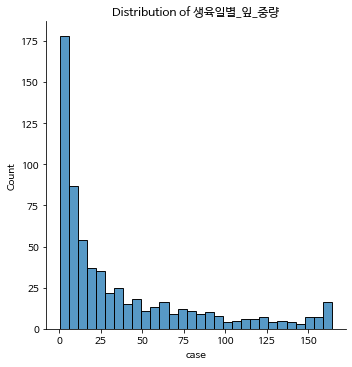

In [ ]:
plt.figure()
sns.displot(train_target['생육일별_잎_중량'], bins=30)
plt.xlabel('case')
plt.title('Distribution of 생육일별_잎_중량')
plt.show()

In [ ]:
# '생육일별_잎_중량' 로그 변환 후 원래 '생육일별_잎_중량' 따로 저장
train_target['log_weight'] = np.log1p(train_target['생육일별_잎_중량'])
train_real_weight = train_target['생육일별_잎_중량'] # 원래 생육일별_잎_중량
print(train_target.head(1))

valid_target['log_weight'] = np.log1p(valid_target['생육일별_잎_중량'])
valid_real_weight = valid_target['생육일별_잎_중량'] # 원래 생육일별_잎_중량
print(valid_target.head(1))

      상추  생육일  생육일별_잎_중량  log_weight
0  case1    1   0.167719    0.155053
         상추  생육일  생육일별_잎_중량  log_weight
644  case24    1   0.171071    0.157919


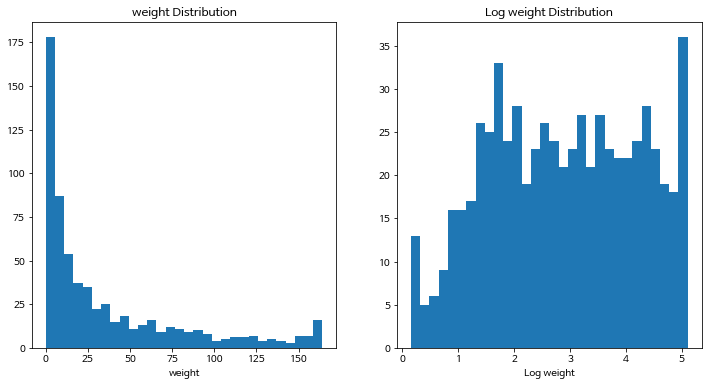

In [ ]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(train_real_weight, bins=30)
ax1.set_title('weight Distribution')
ax1.set_xlabel('weight')

ax2.hist(train_target['log_weight'], bins=30)
ax2.set_title('Log weight Distribution')
ax2.set_xlabel('Log weight')

plt.show()

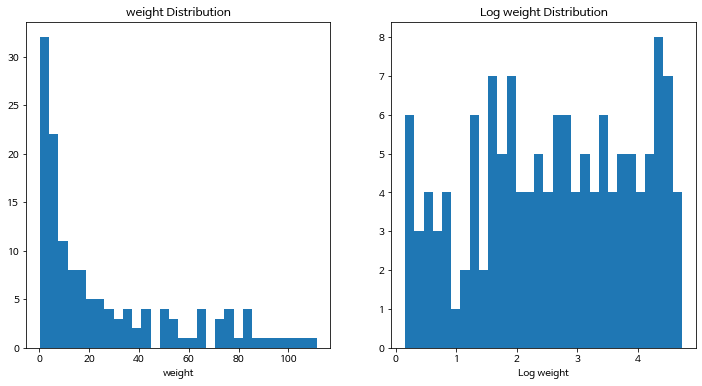

In [ ]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(valid_real_weight, bins=30)
ax1.set_title('weight Distribution')
ax1.set_xlabel('weight')

ax2.hist(valid_target['log_weight'], bins=30)
ax2.set_title('Log weight Distribution')
ax2.set_xlabel('Log weight')

plt.show()

## ◾Modeling   
*   [XGBRegressor_1218_80(light_delete).zip]  
    **제출1) public score: 5.5072071055**  
---

1. 평가지표  
대회의 평가지표는 RMSE이나, 타깃값에 log를 취했기 때문에 RMSE를 구하는게 RMSLE를 구하는 것과 동치.  
학습에는 이를 사용하고, test 파일에서는 역변환을 해서 RMSE가 제대로 평가될 수 있게 진행.

2. 교차검증  

3. 모델 비교  
여러개의 모델을 사용해서 RMSLE를 비교하고, 가장 낮은 RMSLE가 나온 모델을 선정해 튜닝.  
'생육일별_잎_중량'을 예측하는 회귀 모형을 사용.  

  -  모델 목록  
  GradientBoosting Regressor  
  XGBoost Regressor  
  LightGBM Regressor  


In [ ]:
def time_series_df(df, df_target, FEATURES):
  df = df[FEATURES]
  data_list = []
  ts_df = pd.DataFrame()
  for idx in range(len(df_target)): # 644
      time_series = df[24*idx:24*(idx+1)].values  # case1-1, case1-2, case1-3, ...
      time_series = time_series.tolist()
      time_series = sum(time_series, []) # 2 dim -> 1 dim
      time_series_transepose = pd.DataFrame(time_series).transpose()
      ts_df = ts_df.append(time_series_transepose)
      # train_data_list.append(torch.Tensor(time_series))
  return ts_df

FEATURES = ['생육일', '내부온도관측치', '내부습도관측치', 'co2관측치', '시간당분무량', '시간당총광량', '일간누적총광량', 'ec_시간당분무량_시간당총광량']

ts_train_df = time_series_df(train_df, train_target, FEATURES)
ts_valid_df = time_series_df(valid_df, valid_target, FEATURES)
ts_test_df = time_series_df(test_df, test_target, FEATURES)

ts_train_target = train_target['log_weight']
ts_valid_target = train_target['log_weight']
ts_test_target = test_target

In [ ]:
ts_train_valid_df = ts_train_df.append(ts_valid_df).reset_index(drop=True)
ts_train_valid_target_df = train_target.append(valid_target).reset_index(drop=True)
ts_train_valid_target_df = ts_train_valid_target_df['log_weight']

In [ ]:
print(ts_train_valid_df.shape, ts_train_valid_target_df.shape) # log_weight
print(ts_test_df.shape, ts_test_target.shape)   # 상추	생육일	생육일별_잎_중량

(784, 192) (784,)
(140, 192) (140, 3)


In [ ]:
from scipy import sparse

X_train = sparse.csr_matrix(ts_train_valid_df)
Y_train = ts_train_valid_target_df.values 

X_test = ts_test_df
Y_test = test_target

In [ ]:
X_train.shape, Y_train.shape

((784, 192), (784,))

In [ ]:
#Validation function
n_folds = 5

def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, Y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

##### GradientBoostingRegressor

In [ ]:
model_gb = GradientBoostingRegressor(n_estimators=3000, 
                                     learning_rate=0.05,
                                     max_depth=4,
                                     max_features='sqrt',
                                     min_samples_leaf=15,
                                     min_samples_split=10,
                                     loss='huber',
                                     random_state=2020
                                     )

score = rmsle_cv(model_gb)
gb_score = score.mean()
print("GradientBoostingRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

In [ ]:
model_gb.fit(X_train, Y_train)

In [ ]:
pred_gb = model_gb.predict(X_test)
final_pred_sub_gb = np.expm1(pred_gb)
final_pred_sub_gb

In [ ]:
Y_test['생육일별_잎_중량'] = final_pred_sub_gb
Y_test = Y_test.rename(columns={'생육일':'DAT', '생육일별_잎_중량':'predicted_weight_g'})
Y_test

In [ ]:
# for i in range(5):
#   submission = Y_test[i*28:(i*28)+28]
#   submission.to_csv("TEST_0" + str(i+1) + ".csv", mode='w', index=False)

# import zipfile
# path = "/content/drive/MyDrive/01_Prediction/My_Submission/"
# file_list = ['TEST_01.csv', 'TEST_02.csv', 'TEST_03.csv', 'TEST_04.csv', 'TEST_05.csv']
# with zipfile.ZipFile(path + "GradientBoostingRegressor_1.zip", 'w') as my_zip:
#     for i in file_list:
#         my_zip.write(i)
#     my_zip.close()

# Y_test = Y_test.drop(['predicted_weight_g'], axis=1)

##### XGBRegressor(제출1) 

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, 
                             gamma=0.0468, 
                             learning_rate=0.05,
                             min_child_weight=1.7817, 
                             n_estimators=2200,
                             nthread=-1,
                             random_state=7, 
                             reg_alpha=0.464, 
                             reg_lambda=0.8571, 
                             silent=1,
                             subsample=0.5213)

score = rmsle_cv(model_xgb)
xgb_score = score.mean()
print("XGBRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

XGBRegressor score: 0.4532 (0.0715)


In [ ]:
model_xgb.fit(X_train, Y_train)

XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05,
             min_child_weight=1.7817, n_estimators=2200, nthread=-1,
             random_state=7, reg_alpha=0.464, reg_lambda=0.8571, silent=1,
             subsample=0.5213)

In [ ]:
pred_xgb = model_xgb.predict(X_test.values)
final_pred_sub_xgb = np.expm1(pred_xgb)
final_pred_sub_xgb

array([  1.2028502 ,   0.9828249 ,   1.7061999 ,   1.9556837 ,
         2.48512   ,   4.2494655 ,   4.888462  ,   5.280675  ,
         5.7714195 ,   7.972889  ,   9.064538  ,  13.173105  ,
        17.676369  ,  21.075798  ,  23.34953   ,  41.661377  ,
        42.046295  ,  42.39654   ,  46.168415  ,  49.368435  ,
        78.26767   ,  79.00198   ,  92.139656  ,  92.21443   ,
        90.22222   , 100.57579   , 111.60123   , 117.051     ,
         0.76957875,   1.2367334 ,   1.372536  ,   2.2460356 ,
         1.9395559 ,   2.9834936 ,   3.349201  ,   3.9698853 ,
         4.2052655 ,   5.613578  ,   6.089174  ,   8.14071   ,
        11.632849  ,  11.915225  ,  13.145013  ,  17.55626   ,
        23.037498  ,  23.489141  ,  25.139149  ,  27.889328  ,
        35.41092   ,  31.301592  ,  33.468857  ,  42.551292  ,
        38.459877  ,  42.157032  ,  41.7694    ,  56.80256   ,
         1.3893845 ,   1.2141896 ,   1.3991007 ,   2.0073788 ,
         2.2345905 ,   3.1609213 ,   3.2060547 ,   3.49

In [ ]:
Y_test['생육일별_잎_중량'] = final_pred_sub_xgb
Y_test = Y_test.rename(columns={'생육일':'DAT', '생육일별_잎_중량':'predicted_weight_g'})
Y_test

,상추,DAT,predicted_weight_g
0,case29,1,1.202850
1,case29,2,0.982825
2,case29,3,1.706200
3,case29,4,1.955684
4,case29,5,2.485120
...,...,...,...
135,case33,24,57.010395
136,case33,25,66.453674
137,case33,26,78.138962
138,case33,27,69.631073


In [ ]:
for i in range(5):
  submission = Y_test[i*28:(i*28)+28]
  submission.to_csv("TEST_0" + str(i+1) + ".csv", mode='w', index=False)

import zipfile
path = "/content/drive/MyDrive/01_Prediction/My_Submission/"
file_list = ['TEST_01.csv', 'TEST_02.csv', 'TEST_03.csv', 'TEST_04.csv', 'TEST_05.csv']
with zipfile.ZipFile(path + "XGBRegressor_1218_80(light_delete).zip", 'w') as my_zip:
    for i in file_list:
        my_zip.write(i)
    my_zip.close()

Y_test = Y_test.drop(['predicted_weight_g'], axis=1)

##### LGBMRegressor

In [ ]:
# Kfold Train

model_lgb = lgb.LGBMRegressor(bagging_fraction=0.8, 
                              bagging_freq=5, 
                              bagging_seed=9, 
                              feature_fraction=0.2319, 
                              feature_fraction_seed=9,
                              learning_rate=0.05, 
                              max_bin=55, 
                              min_data_in_leaf=6,
                              min_sum_hessian_in_leaf=11, 
                              n_estimators=720, 
                              num_leaves=5,
                              objective='regression')

score = rmsle_cv(model_lgb)
lgb_score = score.mean()
print("LGBMRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

In [ ]:
model_lgb.fit(X_train, Y_train)

In [ ]:
pred_lgb = model_lgb.predict(X_test)
final_pred_sub_lgb = np.expm1(pred_lgb)
final_pred_sub_lgb

In [ ]:
Y_test['생육일별_잎_중량'] = final_pred_sub_lgb
Y_test = Y_test.rename(columns={'생육일':'DAT', '생육일별_잎_중량':'predicted_weight_g'})
Y_test

In [ ]:
# for i in range(5):
#   submission = Y_test[i*28:(i*28)+28]
#   submission.to_csv("TEST_0" + str(i+1) + ".csv", mode='w', index=False)

# import zipfile
# path = "/content/drive/MyDrive/01_Prediction/My_Submission/"
# file_list = ['TEST_01.csv', 'TEST_02.csv', 'TEST_03.csv', 'TEST_04.csv', 'TEST_05.csv']
# with zipfile.ZipFile(path + "LGBMRegressor_1.zip", 'w') as my_zip:
#     for i in file_list:
#         my_zip.write(i)
#     my_zip.close()

# Y_test = Y_test.drop(['predicted_weight_g'], axis=1)

## ◾Modeling  
*   [1219_blending_7.zip]  
  **제출2_) public score: 5.0744434425**  
---

1. 평가지표  
대회의 평가지표는 RMSE이나, 타깃값에 log를 취했기 때문에 RMSE를 구하는게 RMSLE를 구하는 것과 동치.  
학습에는 이를 사용하고, test 파일에서는 역변환을 해서 RMSE가 제대로 평가될 수 있게 진행.

2. 교차검증  

3. 모델 비교  
여러개의 모델을 사용해서 RMSLE를 비교하고, 가장 낮은 RMSLE가 나온 모델을 선정해 튜닝.  
'생육일별_잎_중량'을 예측하는 회귀 모형을 사용.  

  -  모델 목록  
  GradientBoosting Regressor  
  XGBoost Regressor  
  LightGBM Regressor  


In [ ]:
def time_series_df(df, df_target, FEATURES):
  df = df[FEATURES]
  data_list = []
  ts_df = pd.DataFrame()
  for idx in range(len(df_target)): # 644
      time_series = df[24*idx:24*(idx+1)].values  # case1-1, case1-2, case1-3, ...
      time_series = time_series.tolist()
      time_series = sum(time_series, []) # 2 dim -> 1 dim
      time_series_transepose = pd.DataFrame(time_series).transpose()
      ts_df = ts_df.append(time_series_transepose)
      # train_data_list.append(torch.Tensor(time_series))
  return ts_df

FEATURES = ['생육일', '내부온도관측치', '내부습도관측치', 'co2관측치', '시간당분무량', '시간당총광량', '일간누적총광량', 'ec_시간당분무량_시간당총광량']

ts_train_df = time_series_df(train_df, train_target, FEATURES)
ts_valid_df = time_series_df(valid_df, valid_target, FEATURES)
ts_test_df = time_series_df(test_df, test_target, FEATURES)

ts_train_target = train_target['log_weight']
ts_valid_target = train_target['log_weight']
ts_test_target = test_target

In [ ]:
ts_train_valid_df = ts_train_df.append(ts_valid_df).reset_index(drop=True)
ts_train_valid_target_df = train_target.append(valid_target).reset_index(drop=True)
ts_train_valid_target_df = ts_train_valid_target_df['log_weight']

In [ ]:
print(ts_train_valid_df.shape, ts_train_valid_target_df.shape) # log_weight
print(ts_test_df.shape, ts_test_target.shape)   # 상추	생육일	생육일별_잎_중량

(784, 192) (784,)
(140, 192) (140, 3)


In [ ]:
from scipy import sparse

X_train = sparse.csr_matrix(ts_train_valid_df)
Y_train = ts_train_valid_target_df.values 

X_test = ts_test_df
Y_test = test_target

In [ ]:
X_train.shape, Y_train.shape

((784, 192), (784,))

In [ ]:
#Validation function
n_folds = 5

def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, Y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

##### GradientBoostingRegressor

In [ ]:
model_gb = GradientBoostingRegressor(learning_rate=0.05, 
                                     loss='huber', 
                                     max_depth=4,
                                     max_features='sqrt', 
                                     min_samples_leaf=15,
                                     min_samples_split=10, 
                                     n_estimators=3000,
                                     random_state=2020)

score = rmsle_cv(model_gb)
gb_score = score.mean()
print("GradientBoostingRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

GradientBoostingRegressor score: 0.4429 (0.0774)


In [ ]:
model_gb.fit(X_train, Y_train)

GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_depth=4,
                          max_features='sqrt', min_samples_leaf=15,
                          min_samples_split=10, n_estimators=3000,
                          random_state=2020)

In [ ]:
pred_gb = model_gb.predict(X_test)
final_pred_sub_gb = np.expm1(pred_gb)
final_pred_sub_gb

array([  0.78543088,   0.81597064,   1.31162609,   1.61051605,
         2.32489803,   3.37101104,   4.11557382,   5.01312179,
         6.24309315,   7.22361389,   9.16222317,  11.43613794,
        16.39473877,  17.98948612,  14.03223224,  22.93301932,
        26.73562845,  24.26742528,  27.57390494,  34.95582976,
        57.61839879,  56.98641761,  88.33195955,  74.26902367,
        82.01023363,  96.71176631,  98.30152243, 101.7112156 ,
         0.54354253,   1.05587761,   1.41553834,   1.92889734,
         1.76837473,   2.37893934,   3.36528065,   3.93994804,
         4.11205337,   4.58994616,   5.11048342,   7.25655858,
         9.68980871,   9.85767569,  12.31861601,  12.94634182,
        17.55453187,  15.39910659,  16.0599439 ,  19.22973641,
        28.27757935,  26.64294602,  29.25745309,  35.75551354,
        38.77658261,  35.72705611,  36.65665409,  51.74225178,
         1.19112946,   0.92007308,   1.08440562,   1.68000879,
         2.17398325,   2.80276437,   2.75420004,   3.48

In [ ]:
Y_test['생육일별_잎_중량'] = final_pred_sub_gb
Y_test = Y_test.rename(columns={'생육일':'DAT', '생육일별_잎_중량':'predicted_weight_g'})
Y_test

,상추,DAT,predicted_weight_g
0,case29,1,0.785431
1,case29,2,0.815971
2,case29,3,1.311626
3,case29,4,1.610516
4,case29,5,2.324898
...,...,...,...
135,case33,24,38.135077
136,case33,25,47.207978
137,case33,26,57.697422
138,case33,27,60.218647


In [ ]:
for i in range(5):
  submission = Y_test[i*28:(i*28)+28]
  submission.to_csv("TEST_0" + str(i+1) + ".csv", mode='w', index=False)

import zipfile
path = "/content/drive/MyDrive/01_Prediction/My_Submission/"
file_list = ['TEST_01.csv', 'TEST_02.csv', 'TEST_03.csv', 'TEST_04.csv', 'TEST_05.csv']
with zipfile.ZipFile(path + "GradientBoostingRegressor.zip", 'w') as my_zip:
    for i in file_list:
        my_zip.write(i)
    my_zip.close()

# Y_test = Y_test.drop(['predicted_weight_g'], axis=1)

##### XGBRegressor

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, 
                             gamma=0.0468, 
                             learning_rate=0.05,
                             min_child_weight=1.7817, 
                             n_estimators=2200,
                             nthread=-1,
                             random_state=7, 
                             reg_alpha=0.464, 
                             reg_lambda=0.8571, 
                             silent=1,
                             subsample=0.5213)

score = rmsle_cv(model_xgb)
xgb_score = score.mean()
print("XGBRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

XGBRegressor score: 0.4532 (0.0715)


In [ ]:
model_xgb.fit(X_train, Y_train)

XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05,
             min_child_weight=1.7817, n_estimators=2200, nthread=-1,
             random_state=7, reg_alpha=0.464, reg_lambda=0.8571, silent=1,
             subsample=0.5213)

In [ ]:
pred_xgb = model_xgb.predict(X_test.values)
final_pred_sub_xgb = np.expm1(pred_xgb)
final_pred_sub_xgb

array([  1.2028502 ,   0.9828249 ,   1.7061999 ,   1.9556837 ,
         2.48512   ,   4.2494655 ,   4.888462  ,   5.280675  ,
         5.7714195 ,   7.972889  ,   9.064538  ,  13.173105  ,
        17.676369  ,  21.075798  ,  23.34953   ,  41.661377  ,
        42.046295  ,  42.39654   ,  46.168415  ,  49.368435  ,
        78.26767   ,  79.00198   ,  92.139656  ,  92.21443   ,
        90.22222   , 100.57579   , 111.60123   , 117.051     ,
         0.76957875,   1.2367334 ,   1.372536  ,   2.2460356 ,
         1.9395559 ,   2.9834936 ,   3.349201  ,   3.9698853 ,
         4.2052655 ,   5.613578  ,   6.089174  ,   8.14071   ,
        11.632849  ,  11.915225  ,  13.145013  ,  17.55626   ,
        23.037498  ,  23.489141  ,  25.139149  ,  27.889328  ,
        35.41092   ,  31.301592  ,  33.468857  ,  42.551292  ,
        38.459877  ,  42.157032  ,  41.7694    ,  56.80256   ,
         1.3893845 ,   1.2141896 ,   1.3991007 ,   2.0073788 ,
         2.2345905 ,   3.1609213 ,   3.2060547 ,   3.49

In [ ]:
Y_test['생육일별_잎_중량'] = final_pred_sub_xgb
Y_test = Y_test.rename(columns={'생육일':'DAT', '생육일별_잎_중량':'predicted_weight_g'})
Y_test

,상추,DAT,predicted_weight_g
0,case29,1,1.202850
1,case29,2,0.982825
2,case29,3,1.706200
3,case29,4,1.955684
4,case29,5,2.485120
...,...,...,...
135,case33,24,57.010395
136,case33,25,66.453674
137,case33,26,78.138962
138,case33,27,69.631073


In [ ]:
for i in range(5):
  submission = Y_test[i*28:(i*28)+28]
  submission.to_csv("TEST_0" + str(i+1) + ".csv", mode='w', index=False)

import zipfile
path = "/content/drive/MyDrive/01_Prediction/My_Submission/"
file_list = ['TEST_01.csv', 'TEST_02.csv', 'TEST_03.csv', 'TEST_04.csv', 'TEST_05.csv']
with zipfile.ZipFile(path + "XGBRegressor.zip", 'w') as my_zip:
    for i in file_list:
        my_zip.write(i)
    my_zip.close()

Y_test = Y_test.drop(['predicted_weight_g'], axis=1)

##### LGBMRegressor

In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression',
                              num_leaves=5,
                              learning_rate=0.05, 
                              n_estimators=720,
                              max_bin = 55, 
                              bagging_fraction = 0.8,
                              bagging_freq = 5, 
                              feature_fraction = 0.2319,
                              feature_fraction_seed=9, 
                              bagging_seed=9,
                              min_data_in_leaf =6, 
                              min_sum_hessian_in_leaf = 11)

score = rmsle_cv(model_lgb)
lgb_score = score.mean()
print("LGBMRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

LGBMRegressor score: 0.4501 (0.0697)


In [ ]:
model_lgb.fit(X_train, Y_train)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              feature_fraction=0.2319, feature_fraction_seed=9,
              learning_rate=0.05, max_bin=55, min_data_in_leaf=6,
              min_sum_hessian_in_leaf=11, n_estimators=720, num_leaves=5,
              objective='regression')

In [ ]:
pred_lgb = model_lgb.predict(X_test)
final_pred_sub_lgb = np.expm1(pred_lgb)
final_pred_sub_lgb

array([  0.58906448,   0.81256838,   1.39491692,   1.72381276,
         2.43908887,   3.47707017,   3.74691549,   4.85933703,
         5.93766632,   6.69482059,  10.23001896,  12.90112853,
        20.36917458,  19.84468326,  16.1954233 ,  32.10623207,
        29.81622758,  26.26443285,  26.02653331,  33.56350393,
        49.91853405,  54.89998322,  98.88933734,  82.51337367,
        86.04367771,  93.85060742,  89.09286677,  97.03209246,
         0.56875325,   1.1568685 ,   1.57844548,   1.70790818,
         1.91731647,   2.70552323,   3.72282631,   3.93250071,
         4.11104294,   4.57186882,   5.53882615,   8.01553083,
         9.80505121,   8.92002868,  11.46910225,  12.96718716,
        16.68622272,  15.82699548,  17.25531368,  19.37615587,
        29.60016421,  26.10192768,  31.23047569,  38.95885513,
        37.3123827 ,  35.94811438,  37.80593687,  48.73607751,
         1.10642518,   0.8794584 ,   1.15998267,   1.80785214,
         1.74008124,   2.8380157 ,   2.84146316,   3.48

In [ ]:
Y_test['생육일별_잎_중량'] = final_pred_sub_lgb
Y_test = Y_test.rename(columns={'생육일':'DAT', '생육일별_잎_중량':'predicted_weight_g'})
Y_test

,상추,DAT,predicted_weight_g,predicted_weight_g
0,case29,1,1.202850,0.589064
1,case29,2,0.982825,0.812568
2,case29,3,1.706200,1.394917
3,case29,4,1.955684,1.723813
4,case29,5,2.485120,2.439089
...,...,...,...,...
135,case33,24,57.010395,46.908417
136,case33,25,66.453674,54.552939
137,case33,26,78.138962,58.447381
138,case33,27,69.631073,57.408777


In [ ]:
for i in range(5):
  submission = Y_test[i*28:(i*28)+28]
  submission.to_csv("TEST_0" + str(i+1) + ".csv", mode='w', index=False)

import zipfile
path = "/content/drive/MyDrive/01_Prediction/My_Submission/"
file_list = ['TEST_01.csv', 'TEST_02.csv', 'TEST_03.csv', 'TEST_04.csv', 'TEST_05.csv']
with zipfile.ZipFile(path + "LGBMRegressor.zip", 'w') as my_zip:
    for i in file_list:
        my_zip.write(i)
    my_zip.close()

Y_test = Y_test.drop(['predicted_weight_g'], axis=1)

##### Blending(제출2) 

In [ ]:
total_weight = (1./gb_score) + (1./xgb_score) + (1./lgb_score)
pred = (pred_gb * (1./gb_score) + pred_xgb * (1./xgb_score) +  pred_lgb * (1./lgb_score))/total_weight
final_pred_sub_Ensemble = np.expm1(pred)
final_pred_sub_Ensemble

array([  0.84092039,   0.86825101,   1.46382932,   1.75837993,
         2.41504421,   3.6804337 ,   4.22713617,   5.04783017,
         5.98322863,   7.27878733,   9.47187263,  12.47391565,
        18.0679911 ,  19.58484876,  17.43090169,  31.25979414,
        32.2070682 ,  29.97768112,  32.09514793,  38.66200122,
        60.79560599,  62.70300539,  92.99615479,  82.61052584,
        85.99575668,  96.99765192,  99.21272554, 104.88545198,
         0.62345908,   1.14783536,   1.45391184,   1.95199227,
         1.87333417,   2.67861253,   3.47553747,   3.94732581,
         4.14228746,   4.90252678,   5.56362661,   7.7916352 ,
        10.33577367,  10.15760106,  12.29149699,  14.33214527,
        18.89001899,  17.88009576,  19.08634466,  21.80835935,
        30.92710231,  27.91020495,  31.25701409,  38.96637131,
        38.18041267,  37.8125514 ,  38.66665227,  52.31115946,
         1.22531338,   0.99828197,   1.20939299,   1.82733736,
         2.04158374,   2.92943357,   2.92753928,   3.48

In [ ]:
Y_test['생육일별_잎_중량'] = final_pred_sub_Ensemble
Y_test = Y_test.rename(columns={'생육일':'DAT', '생육일별_잎_중량':'predicted_weight_g'})
Y_test

,상추,DAT,predicted_weight_g
0,case29,1,0.850726
1,case29,2,0.891376
2,case29,3,1.578967
3,case29,4,1.774696
4,case29,5,2.469179
...,...,...,...
135,case33,24,46.002250
136,case33,25,53.823933
137,case33,26,65.440266
138,case33,27,61.459008


In [ ]:
for i in range(5):
  submission = Y_test[i*28:(i*28)+28]
  submission.to_csv("TEST_0" + str(i+1) + ".csv", mode='w', index=False)

import zipfile
path = "/content/drive/MyDrive/01_Prediction/My_Submission/"
file_list = ['TEST_01.csv', 'TEST_02.csv', 'TEST_03.csv', 'TEST_04.csv', 'TEST_05.csv']
with zipfile.ZipFile(path + "1219_blending_7.zip", 'w') as my_zip:
    for i in file_list:
        my_zip.write(i)
    my_zip.close()

# Y_test = Y_test.drop(['predicted_weight_g'], axis=1)

## Model Weight 저장 

In [ ]:
import pickle

# 모델 정의 및 학습
xgb_model = model_xgb

# 파일명
filename = '/content/drive/MyDrive/01_Prediction/weights/xgb_model.model'

# 모델 저장
pickle.dump(xgb_model, open(filename, 'wb'))

# 모델 불러오기
xgb_model = pickle.load(open(filename, 'rb'))